# Week 5 - Classifying Meanings & Documents (With Machine Learning)

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data.

In [126]:
# run if on Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-wsxh2k32
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-wsxh2k32
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done


# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain (We'll see how far Large Language Models can go). Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [128]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#drive/MyDrive/{where you store on Google Drive}/data/pyAnno/testdata_numerical.txt"
x = np.loadtxt("/content/drive/MyDrive/macss60000/week5/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [129]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [130]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [131]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [132]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


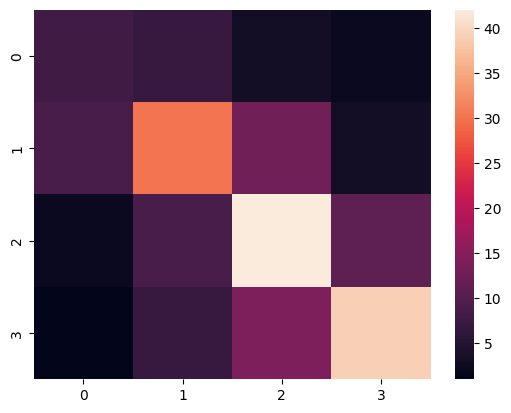

In [133]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [134]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [135]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [136]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [137]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [138]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


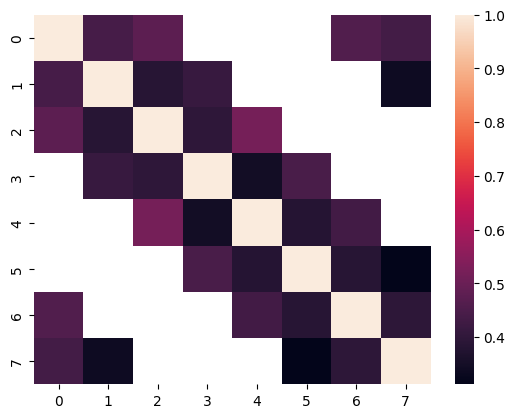

In [139]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others.

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [140]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)

pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [141]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [142]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

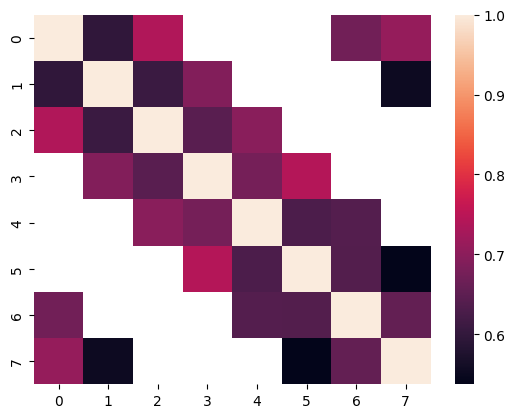

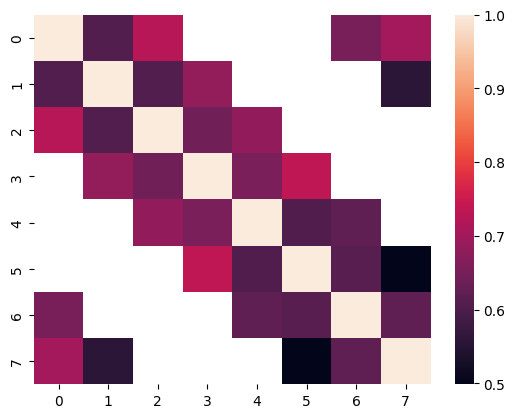

In [143]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [144]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/54694/files/folder/unfiled?preview=10675152), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [145]:
#3 people do the content annotation
n_x = np.loadtxt('/content/drive/MyDrive/60000/burnouttest.txt')
anno_new = AnnotationsContainer.from_array(n_x)

In [146]:
anno_new

In [147]:
anno_new.labels

[0.0, 1.0, 2.0, 3.0]

In [148]:
anno_new.missing_values

[]

In [149]:
pyanno.measures.agreement.labels_frequency(anno_new.annotations,4)

array([0.1       , 0.13333333, 0.36666667, 0.4       ])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 1. 0.]
 [0. 1. 2. 3.]]


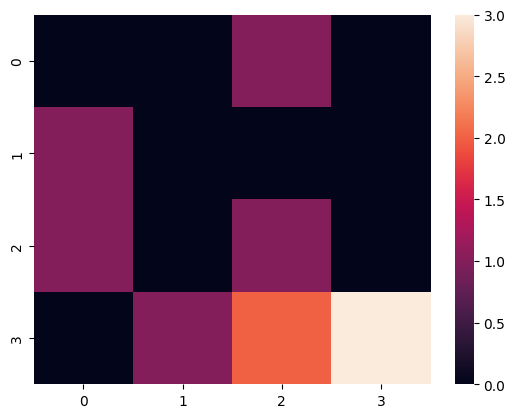

In [150]:
cn = pyanno.measures.agreement.confusion_matrix(anno_new.annotations[:,0], anno_new.annotations[:,1],4)
print(cn)
ac = seaborn.heatmap(cn)
plt.show()

In [151]:
scotts_pi(anno_new.annotations[:,0], anno_new.annotations[:,1])

0.11111111111111112

In [152]:
fleiss_kappa(anno_new.annotations[::])

-0.08196721311475413

In [153]:
krippendorffs_alpha(anno_new.annotations[::])

0.20215311004784697

In [154]:
cohens_kappa(anno_new.annotations[:,0], anno_new.annotations[:,1])

0.15492957746478872

In [155]:
m_new = pairwise_matrix(cohens_kappa, anno_new.annotations)
print(m_new)

[[ 1.00000000e+00  1.54929577e-01  7.93016446e-17]
 [ 1.54929577e-01  1.00000000e+00 -3.04347826e-01]
 [ 7.93016446e-17 -3.04347826e-01  1.00000000e+00]]


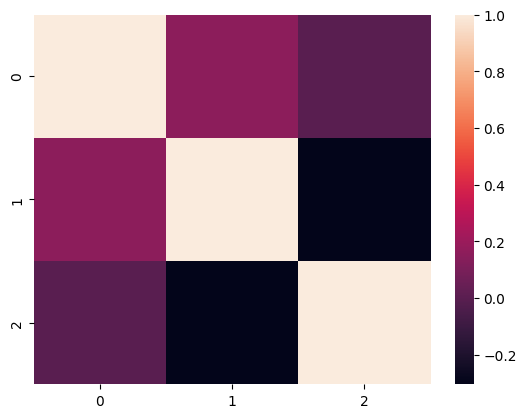

In [156]:
ax_new = seaborn.heatmap(m_new)
plt.show()

In [157]:
pairwise_metric_average(cohens_kappa, anno_new.annotations)

-0.04980608287405594

In [158]:
cohens_weighted_kappa(anno_new.annotations[:,0], anno_new.annotations[:,1])

0.23728813559322037

In [159]:
pairwise_metric_average(cohens_weighted_kappa,anno_new.annotations)

0.034651600753295576

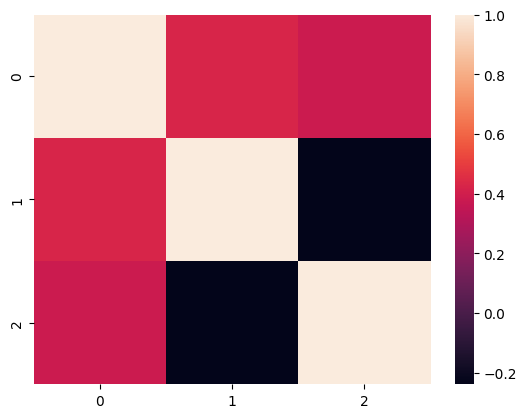

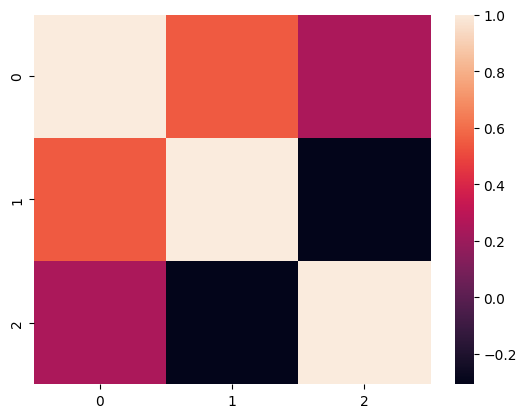

In [160]:
n = pairwise_matrix(pearsons_rho, anno_new.annotations)
m = pairwise_matrix(spearmans_rho, anno_new.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

In [161]:
print(pairwise_metric_average(pearsons_rho,anno_new.annotations), pairwise_metric_average(spearmans_rho,anno_new.annotations))

0.190009525108742 0.16285089385318935


### For my dataset about burnout text, Scott's Pi (π) result, 0.1111, suggests a low agreement level that's only slightly above chance, indicating considerable variability among annotators. In summary, all these measures result suggest that there is a high degree of variability in annotator's decisions. For emotion text people have a very subjective understanding of emotional expression.

# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`).

The four data patterns include:
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [162]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [163]:
noise = .2

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [164]:
dfTrain

,vect,category
215,"[-0.2596014229188519, 0.2269179925988677]",1
640,"[0.008452688062073036, 0.285115786507399]",0
961,"[-0.03732039706700616, -0.3192244391458099]",1
978,"[0.16391350003271515, -0.13853730758213803]",0
651,"[0.614231736360531, -0.41380346796259987]",1
...,...,...
817,"[-0.4451132406108152, -0.4716009990178789]",1
949,"[0.4658450120692809, 0.44596052346697634]",1
614,"[0.1061034455359643, -0.13817358860250156]",0
405,"[-0.27499576222041544, 0.10829276355199073]",1


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [165]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

/usr/local/lib/python3.10/dist-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


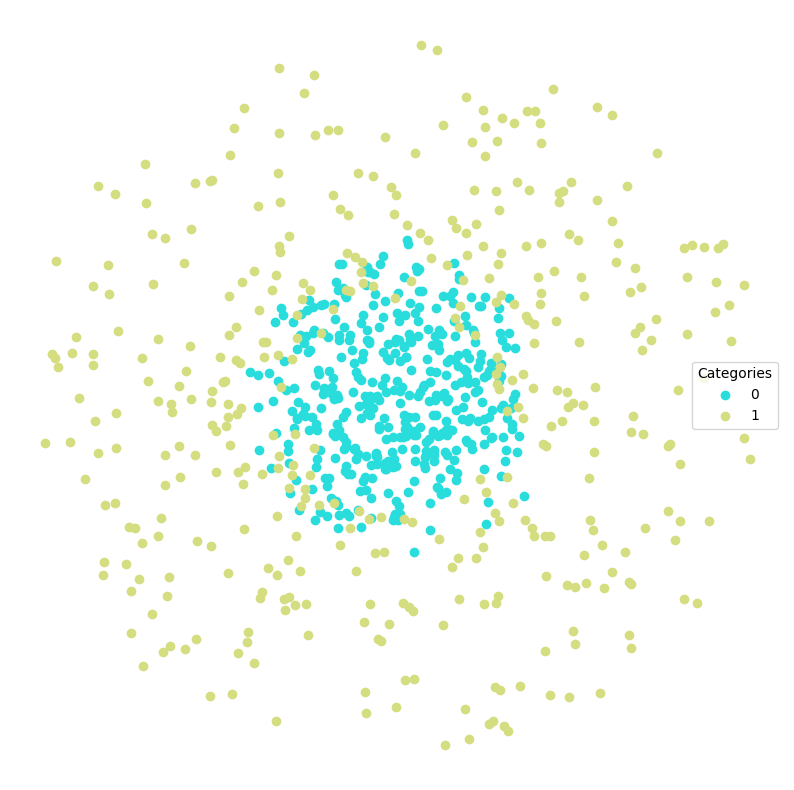

In [166]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [167]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [168]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 '_sklearn_threadpool_controller',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'naive_bayes',
 'neighbors',
 'neural_network',
 'os',
 'pipeline',
 'preprocessing',
 'random',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [169]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(weights='distance')

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [170]:
dfTrain['vect']

215      [-0.2596014229188519, 0.2269179925988677]
640      [0.008452688062073036, 0.285115786507399]
961    [-0.03732039706700616, -0.3192244391458099]
978    [0.16391350003271515, -0.13853730758213803]
651      [0.614231736360531, -0.41380346796259987]
                          ...                     
817     [-0.4451132406108152, -0.4716009990178789]
949      [0.4658450120692809, 0.44596052346697634]
614     [0.1061034455359643, -0.13817358860250156]
405    [-0.27499576222041544, 0.10829276355199073]
232      [0.2542870561725707, 0.07751303032926792]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [171]:
np.stack(dfTrain['vect'])

array([[-0.25960142,  0.22691799],
       [ 0.00845269,  0.28511579],
       [-0.0373204 , -0.31922444],
       ...,
       [ 0.10610345, -0.13817359],
       [-0.27499576,  0.10829276],
       [ 0.25428706,  0.07751303]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [172]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.13,0.870767,0.845361,0.800372,0.881720
1,0.13,0.870767,0.893204,0.842988,0.859813


This lets us look at which classes do better:

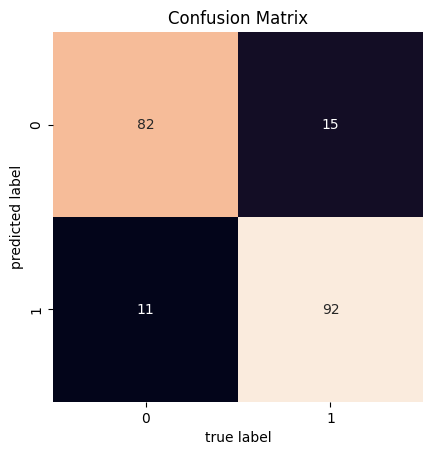

In [173]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

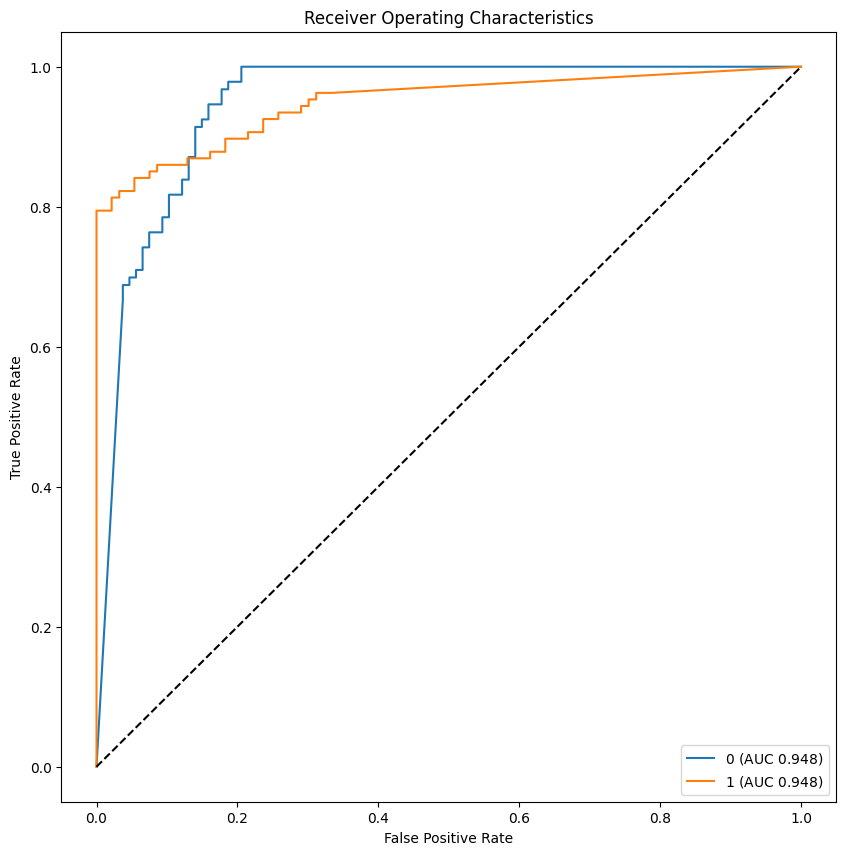

In [174]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


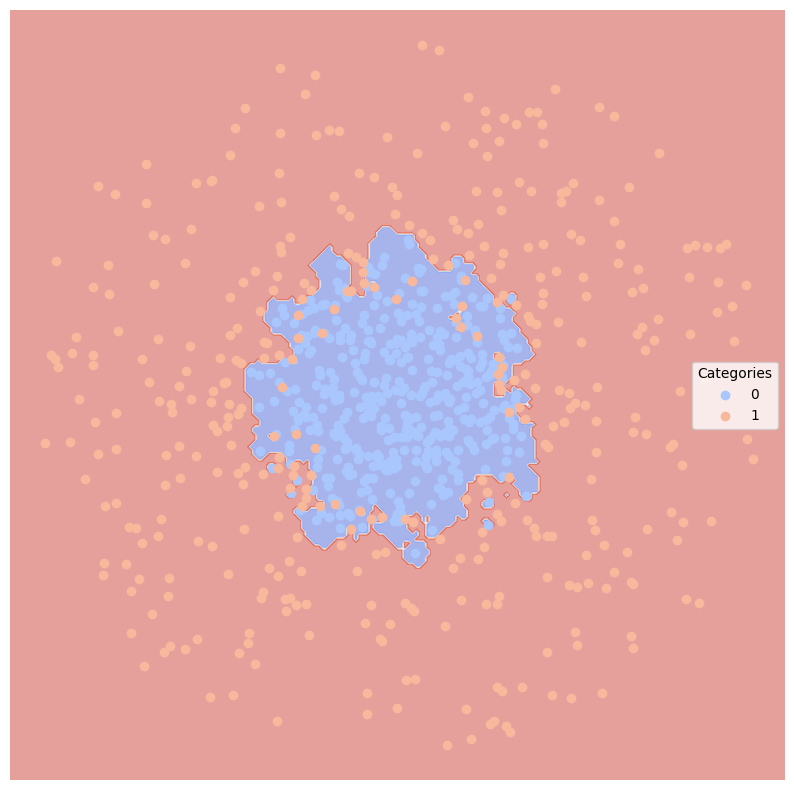

In [175]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

Note that if you're on Google Colab and have not `git clone`ed the [class repo](https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter), you can set a `dataDirectory=` parameter in the loadReddit function to match the data folder path on Colab.

In [176]:
# dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='../data/'), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='/content/drive/MyDrive/macss60000/week5/'), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

Loading Reddit data
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [177]:
dfTrain

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,category,tokenized_text,normalized_text,vect
952,952,shibesandmemes,False,167,Weeaboo Tales: stories about the extreme fans ...,I'm a freshman and this week i was sitting alo...,"Yelling ""hentai"" on the bus with this weeb's f...",https://www.reddit.com/r/weeabootales/comments...,Weeaboo Tales,"[I, 'm, a, freshman, and, this, week, i, was, ...","[m, freshman, week, sit, bus, surprise, surpri...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
667,667,20_cats,False,36,Bad Roommates: Tales of Irritation,"After a week or so, things went back to normal...",Master Cringe - The Domestic God (Part 2),https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[After, a, week, or, so, things, went, back, t...","[week, thing, go, normal, master, cringe, stop...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0446567816824..."
1043,1043,michybears,False,132,Weeaboo Tales: stories about the extreme fans ...,"Hello, I have submitted here before, but I now...",The Tale of Eren-chan,https://www.reddit.com/r/weeabootales/comments...,Weeaboo Tales,"[Hello, I, have, submitted, here, before, but,...","[hello, submit, return, recent, story, story, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
322,322,roadhammer86,False,2821,Tales From Tech Support,"So, I currently co-own a small web development...",This sub landed me a job today.,https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[So, I, currently, co, own, a, small, web, dev...","[currently, co, small, web, development, graph...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
765,765,Bebopvox001,False,28,Bad Roommates: Tales of Irritation,Probably not as bad as some of the others I've...,My Awkward Roommate Situation,https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[Probably, not, as, bad, as, some, of, the, ot...","[probably, bad, ve, read, go, currently, live,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1301,1301,throwaway77636676,False,3375,Relationships,My fiance dated a guy before me that she was i...,My[30/M] fiance[29/F] told me that she would l...,https://www.reddit.com/r/relationships/comment...,Relationships,"[My, fiance, dated, a, guy, before, me, that, ...","[fiance, date, guy, incredibly, love, know, da...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1531,1531,hw32,False,2216,Relationships,https://www.reddit.com/r/relationships/comment...,Me [33 M] widower I am scared to death about p...,https://www.reddit.com/r/relationships/comment...,Relationships,[https://www.reddit.com/r/relationships/commen...,[https://www.reddit.com/r/relationships/commen...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27,27,Clickity_clickity,False,7203,Tales From Tech Support,Part 1 [Part 2](http://www.reddit.com/r/talesf...,"Jack, the Worst End User, Part 1.",https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[Part, 1, Part, 2](http://www.reddit.com, r, t...","[2](http://www.reddit.com, r, talesfromtechsup...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1436,1436,chris0427,False,2513,Relationships,https://www.reddit.com/r/relationships/comment...,Updating on my girlfriend [27F] got massive ta...,https://www.reddit.com/r/relationships/comment...,Relationships,[https://www.reddit.com/r/relationships/commen...,[https://www.reddit.com/r/relationships/commen...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [178]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [179]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression()

In [180]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales,0.009375,0.981481,1.000000,0.972338,0.962963
Relationships,0.040625,0.952705,0.905882,0.866271,0.939024
Tales From Tech Support,0.003125,0.997917,0.987654,0.987654,1.000000
Bad Roommates,0.034375,0.950751,0.934211,0.880165,0.922078


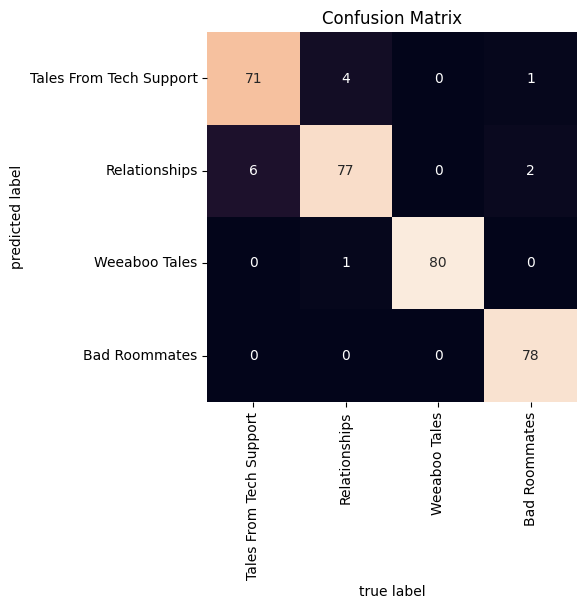

In [181]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

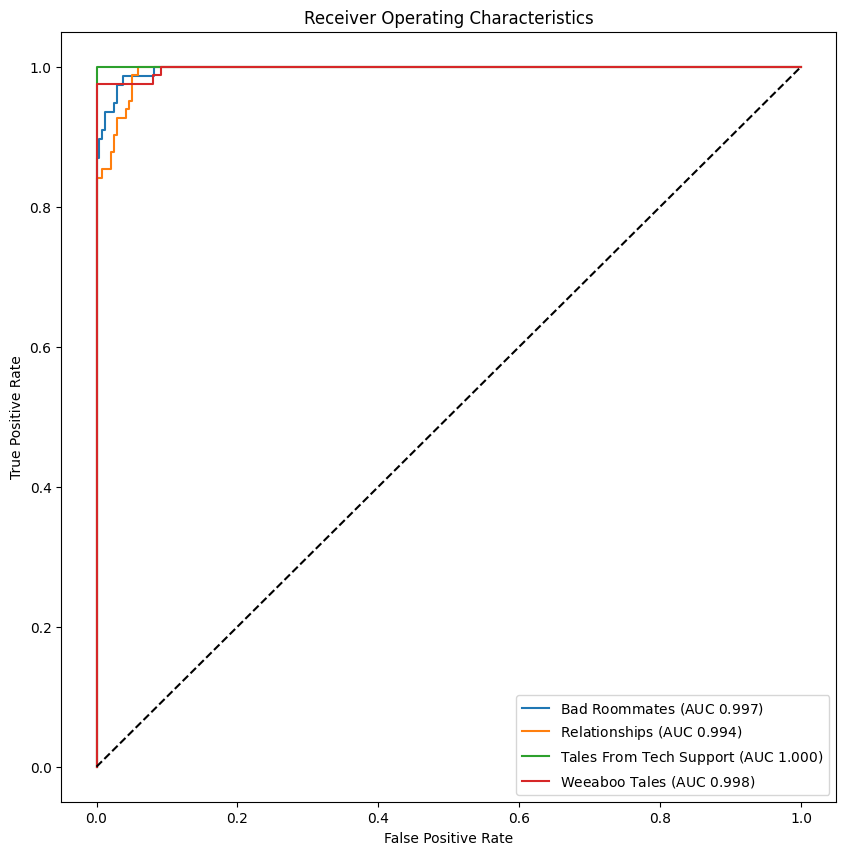

In [182]:
lucem_illud.plotMultiROC(clf, dfTest)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


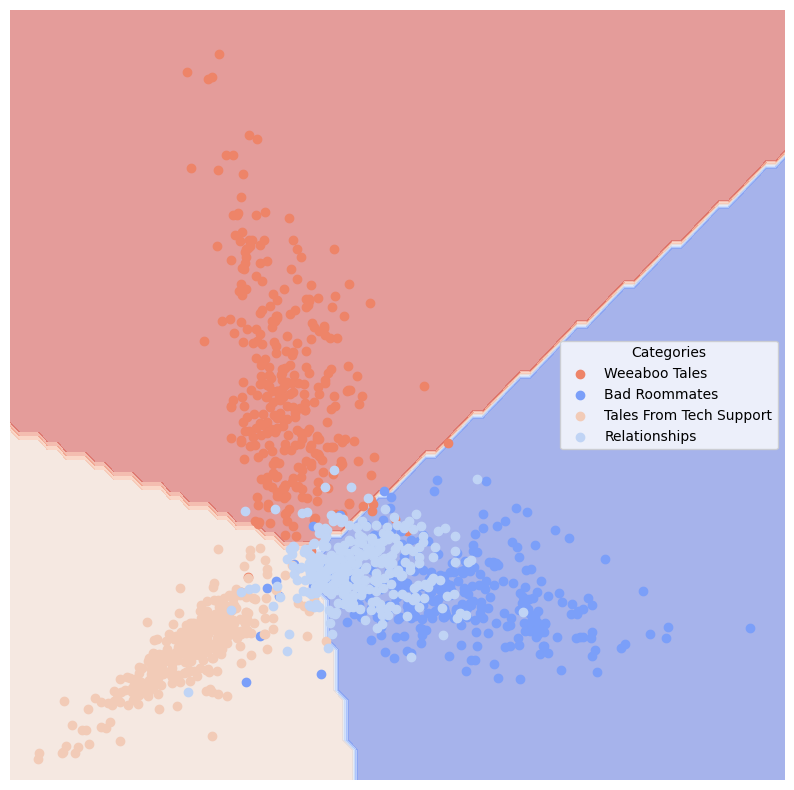

In [183]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [184]:
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [185]:
# Function to get predictions and confusion matrix
def predict_and_confuse(clf, testDF):
    test_vectors = np.stack(testDF['vect'], axis=0)
    predictions = clf.predict(test_vectors)
    confusion_mat = sklearn.metrics.confusion_matrix(testDF['category'], predictions)
    return predictions, confusion_mat

In [186]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, categories, clf_name, ax):
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, ax=ax,
                xticklabels=categories, yticklabels=categories)
    ax.set_title(f"Confusion Matrix: {clf_name}")
    ax.set_xlabel('True label')
    ax.set_ylabel('Predicted label')

In [187]:
# Function to fit classifier and evaluate performance
def fit_and_evaluate(clf, trainDF, testDF):
    train_vectors = np.stack(trainDF['vect'], axis=0)
    clf.fit(train_vectors, trainDF['category'])
    performance = lucem_illud.evaluateClassifier(clf, testDF)
    print(f"Evaluation metrics for {clf.__class__.__name__}:")
    print(performance)
    return clf, performance

In [188]:
# Function to perform classification and plotting for all algorithms
def classify_and_plot(trainDF, testDF, algorithms):
    performance_list = []
    unique_categories = testDF['category'].unique()
    print(f"Unique categories for plotting: {unique_categories}")  # Debugging line
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))  # Adjust size as needed
    axes = axes.flatten()

    for idx, (name, clf) in enumerate(algorithms.items()):
        print(f"Training and evaluating {name}")
        clf, performance = fit_and_evaluate(clf, trainDF, testDF)
        print(f"Performance for {name}:")
        print(performance)
        performance_list.append(performance)

        predictions, cm = predict_and_confuse(clf, testDF)
        plot_confusion_matrix(cm, unique_categories, name, axes[idx])

    plt.tight_layout()
    plt.show()

    # Concatenate performance data
    output = pd.concat(performance_list, ignore_index=True)
    output.index = pd.MultiIndex.from_product([algorithms.keys(), unique_categories],
                                              names=['Algorithm', 'Category'])
    return output

In [ ]:
# Main function to run classification
def main_classification(trainDF, testDF):
    algorithms = {
        "KN_Neighbors": sklearn.neighbors.KNeighborsClassifier(1000, weights='uniform'),
        "Logistic_Regression": LogisticRegression(),
        "Naive_Bayes": GaussianNB(),
        "SVC": SVC(kernel='linear', probability=True),
        "Decision_Tree": DecisionTreeClassifier(),
        "Random_Forest": RandomForestClassifier(),
        "Neural_Network": MLPClassifier(),
        "Gradient_Boosting": GradientBoostingClassifier()
    }

    return classify_and_plot(trainDF, testDF, algorithms)

## Dataset NewsGroups 1 - 4

In [ ]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Unique categories for plotting: ['rec.autos' 'comp.sys.mac.hardware' 'misc.forsale' 'comp.windows.x']
Training and evaluating KN_Neighbors


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation metrics for KNeighborsClassifier:
                       Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                                    
rec.autos                0.251064  0.5   0.000000           0.251064     0.0
misc.forsale             0.253191  0.5   0.000000           0.253191     0.0
comp.sys.mac.hardware    0.229787  0.5   0.000000           0.229787     0.0
comp.windows.x           0.734043  0.5   0.265957           0.265957     1.0
Performance for KN_Neighbors:
                       Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                                    
rec.autos                0.251064  0.5   0.000000           0.251064     0.0
misc.forsale             0.253191  0.5   0.000000           0.253191     0.0
comp.sys.mac.hardware    0.229787  0.5   0.000000           0.229787     0.0
comp.windows.x           0.734043  0.5   0.265957           0.265957     1.0
T

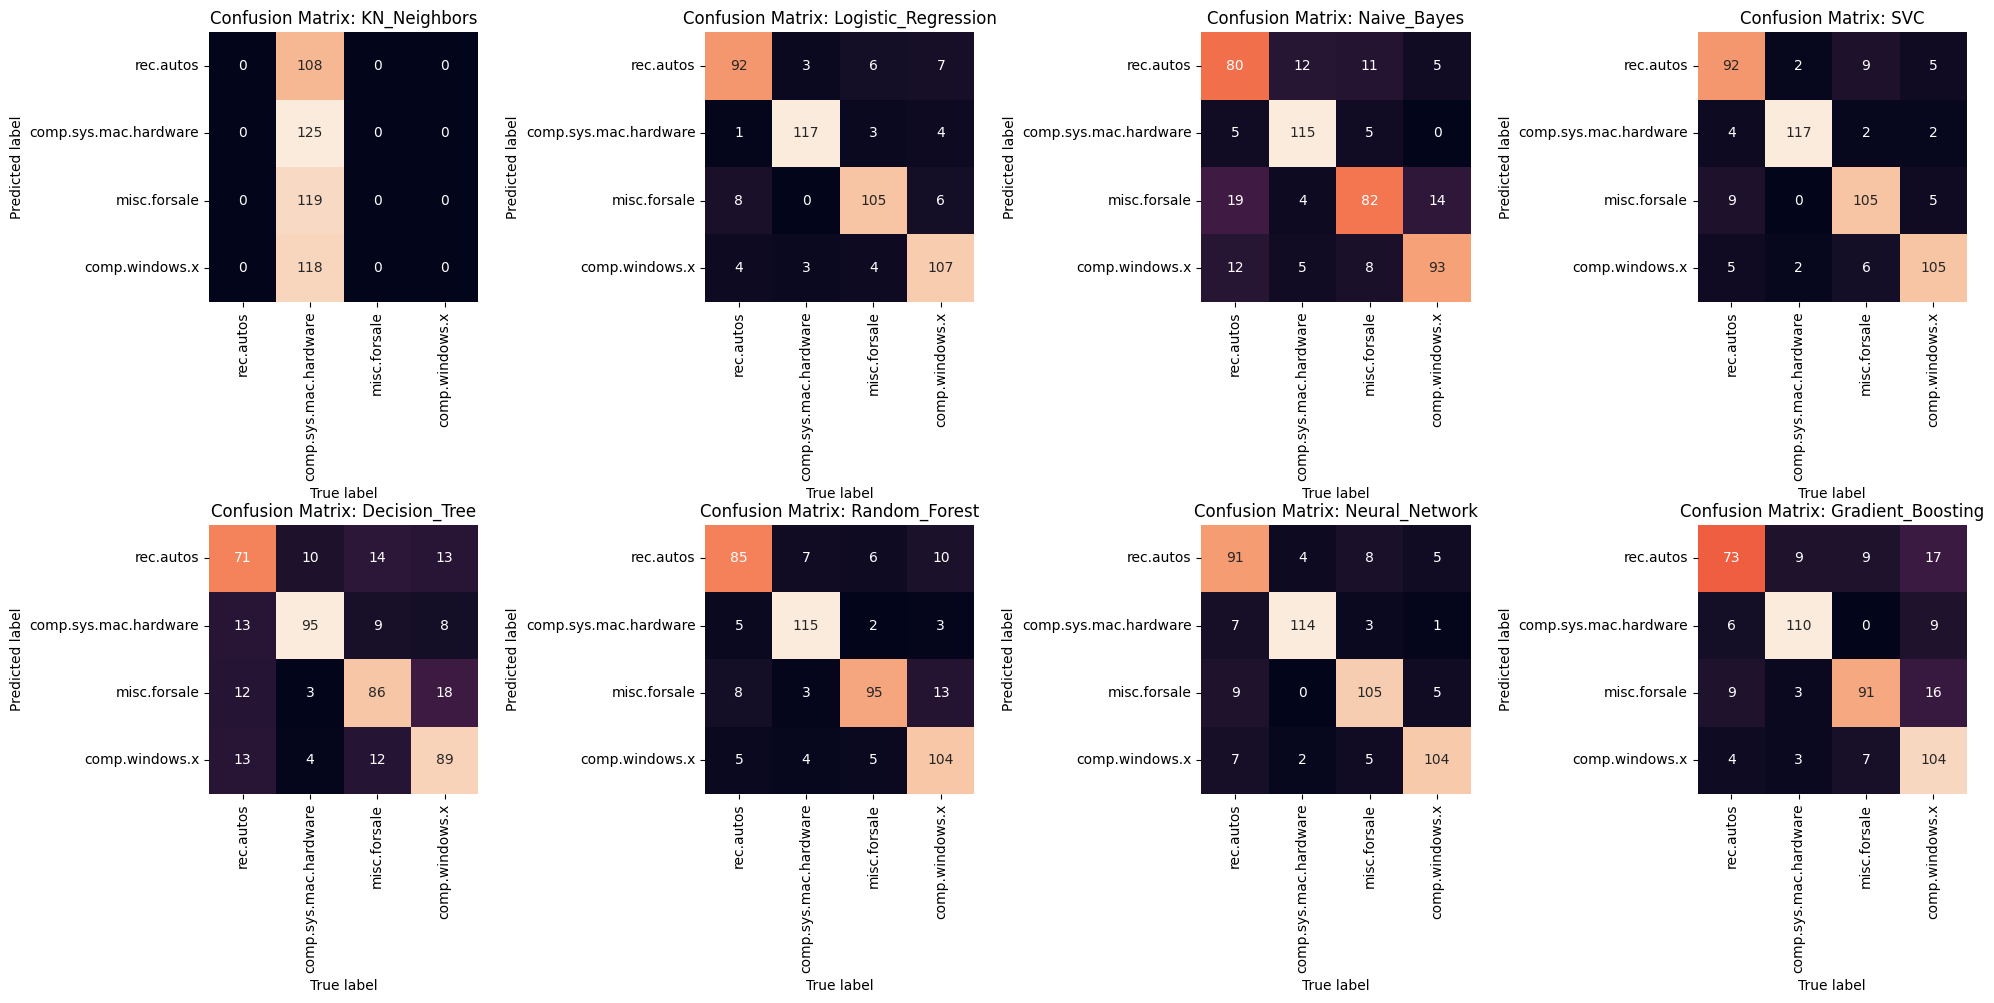

In [ ]:
final_performance = main_classification(dfTrain, dfTest)

 ## For NewsGroups data:
 The LogisticRegression model performed best on most metrics, especially AUC, accuracy, average accuracy, and recall rates. For example, in the comp.windows.x category, the logistic regression model has an AUC of 0.959304, an accuracy of 0.951220, an average accuracy of 0.907363, and a recall rate of 0.936,000, which is one of the highest performances of any model. SVC (Support vector Classifier) also performed well, especially in the comp.windows.x category, with an error rate of 0.025532, an AUC of 0.962203, an accuracy of 0.966942, an average accuracy of 0.922079, and a recall rate of 0.936,000. These indicators are close to or slightly above the performance of logistic regression models. Neural networks (MLPClassifier) and Random forests (RandomForestClassifier) also performed well, but in most categories, their metrics were slightly lower than logistic regression and SVC models.

## Dataset SenateSmall 5

In [189]:
dfTrainSmall, dfTestSmall = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(dataDirectory='/content/drive/MyDrive/macss60000/week5/'), test_size=.2)

Loading senate data
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Unique categories for plotting: ['Clinton' 'Obama']
Training and evaluating KN_Neighbors


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation metrics for KNeighborsClassifier:
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
Obama       0.400585  0.5   0.000000           0.400585     0.0
Clinton     0.400585  0.5   0.599415           0.599415     1.0
Performance for KN_Neighbors:
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
Obama       0.400585  0.5   0.000000           0.400585     0.0
Clinton     0.400585  0.5   0.599415           0.599415     1.0
Training and evaluating Logistic_Regression
Evaluation metrics for LogisticRegression:
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Obama       0.020468  0.974453   1.000000           0.969373  0.948905
Clinton     0.020468  0.974453   0.966981           0.966981  1.000000
Performance for Logistic_Regression:
     

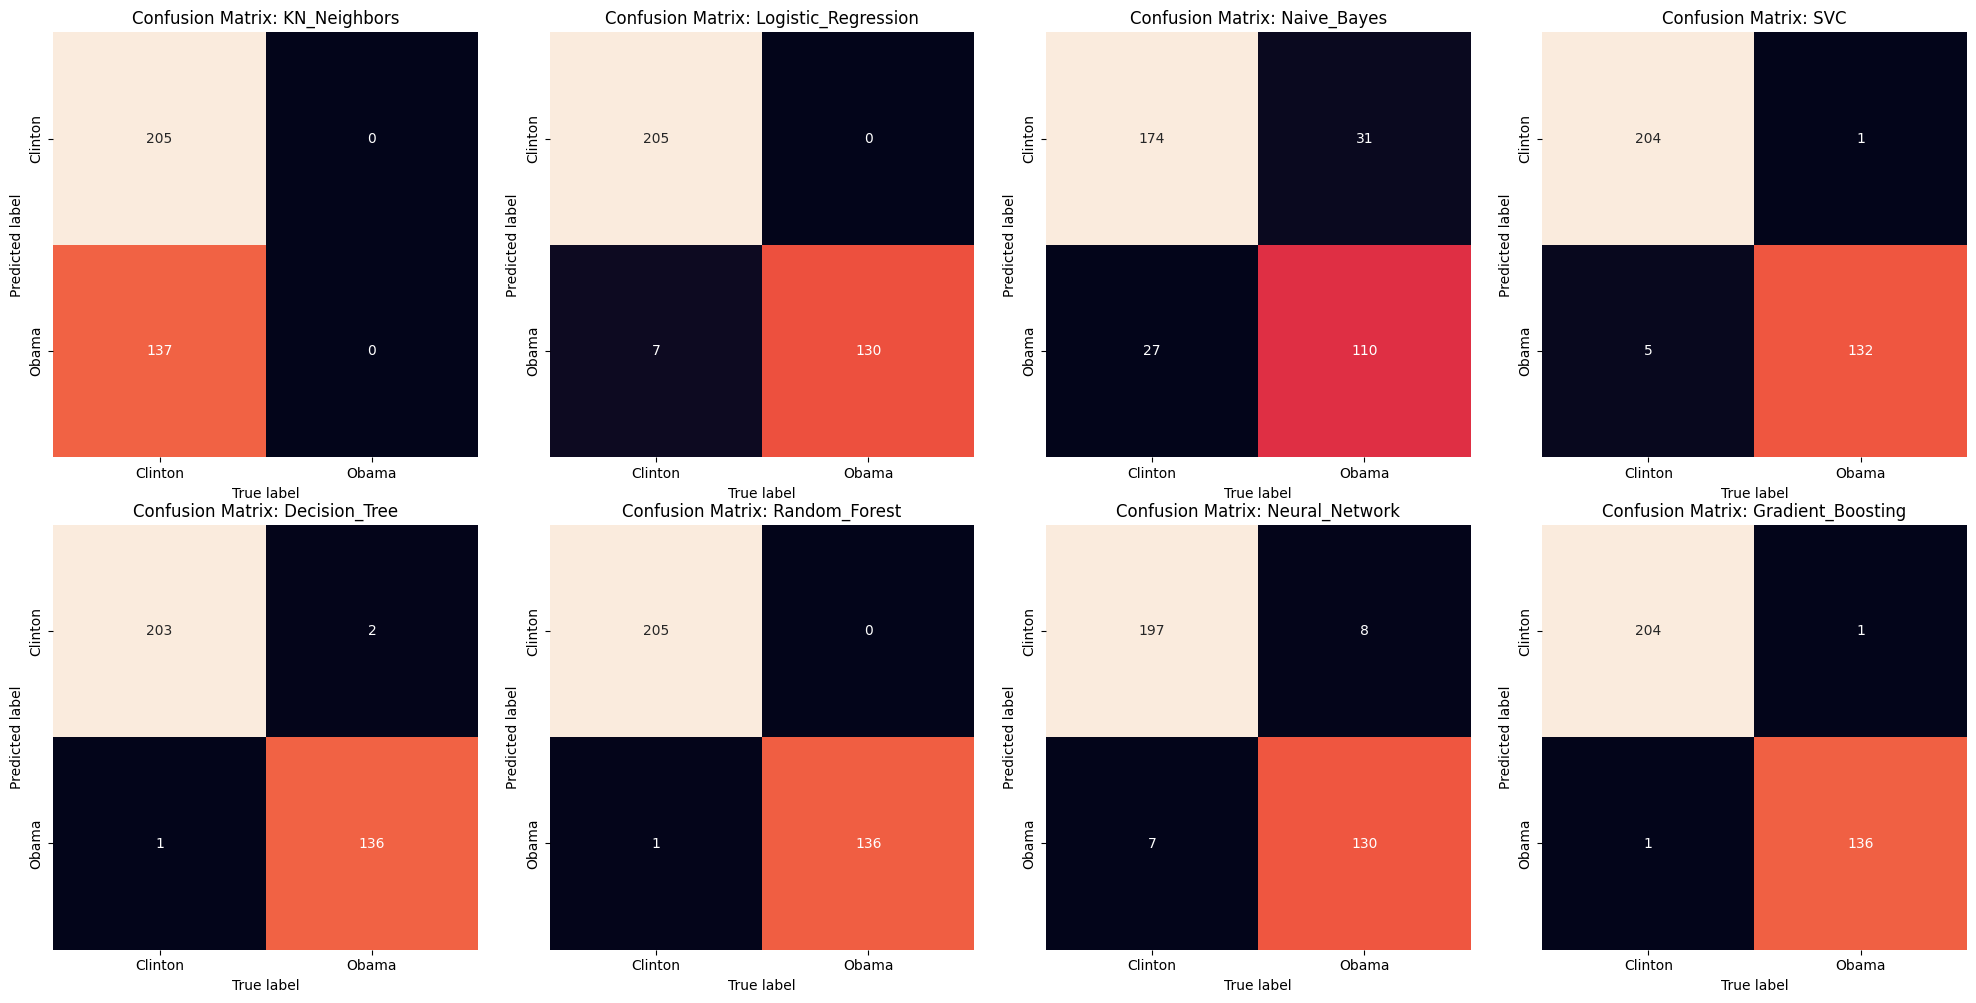

In [ ]:
final_performance_SenateSmall = main_classification(dfTrainSmall, dfTestSmall)

### The RandomForestClassifier
RandomForestClassifier model performed best. The performance of the random forest model on the Obama and Clinton categories is as follows: For the Obama category, the error rate is only 0.002924, the AUC value is 0.99635, the accuracy and average accuracy are near perfect, and the recall rate is 0.992701. For the Clinton category, the error rate is also 0.002924, the AUC value is also 0.99635, the accuracy is 0.995146, and the average accuracy and recall rate are both 1.000000.

Although the DecisionTreeClassifier and GradientBoostingClassifier also did well, especially on specific indicators are close to or equivalent performance, but considering all the indicators, The stability and efficient performance of random forests make it the best-performing model on this dataset

## Dataset Spam 6-7

In [ ]:
dfTrainSpam, dfTestSpam = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(dataDirectory='/content/drive/MyDrive/macss60000/week5/'), test_size=.2)

Loading Spam
Loading Ham
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Unique categories for plotting: ['not spam' 'spam']
Training and evaluating KN_Neighbors


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation metrics for KNeighborsClassifier:
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
not spam    0.156204  0.5   0.843796           0.843796     1.0
spam        0.156204  0.5   0.000000           0.156204     0.0
Performance for KN_Neighbors:
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
not spam    0.156204  0.5   0.843796           0.843796     1.0
spam        0.156204  0.5   0.000000           0.156204     0.0
Training and evaluating Logistic_Regression
Evaluation metrics for LogisticRegression:
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
not spam    0.118248  0.625303   0.878234           0.878175  0.998270
spam        0.118248  0.625303   0.964286           0.360113  0.252336
Performance for Logistic_Regression:
     

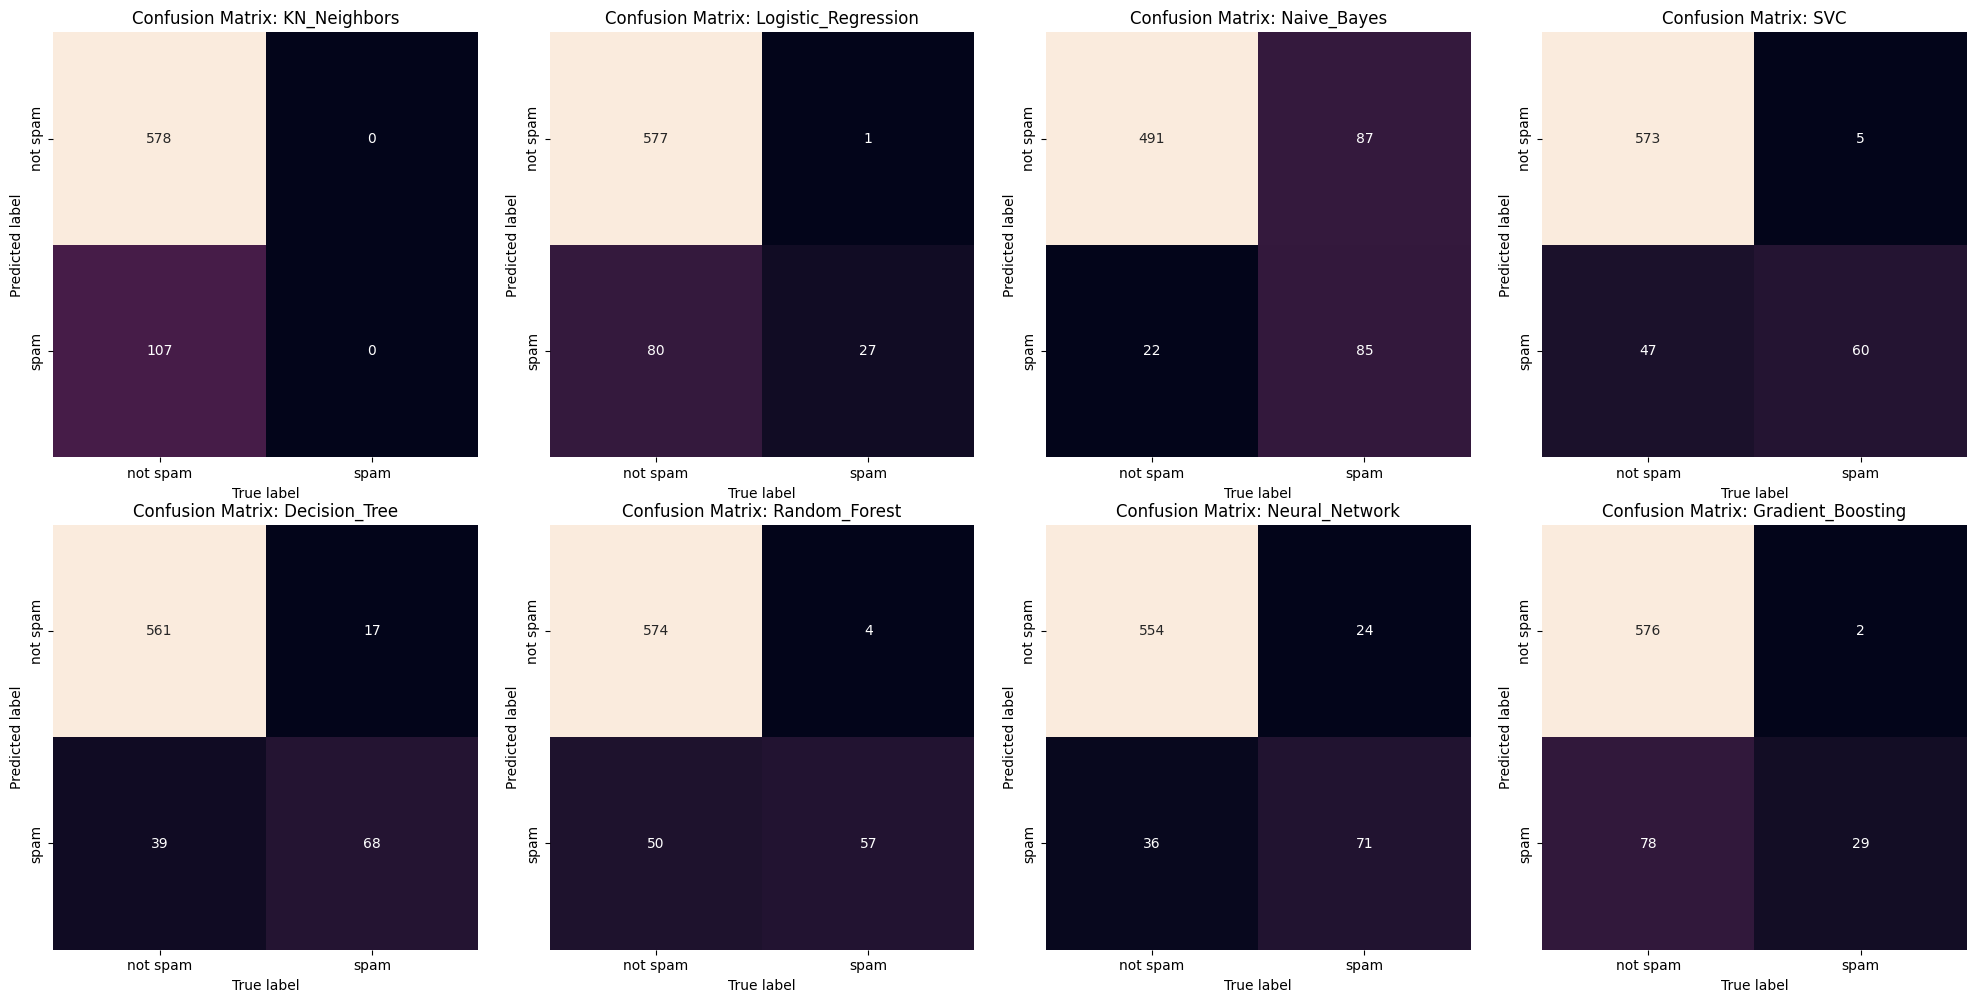

In [ ]:
final_performance_Spam = main_classification(dfTrainSpam, dfTestSpam)

### For spam data

For the not spam category, the error rate is 0.075912, AUC is 0.776049, precision is 0.924194, average precision is 0.923498, and recall is 0.991349.
For the spam category, the error rate is 0.075912, AUC is 0.776049, precision is 0.923077, average precision is 0.586226, and recall is 0.560748.
Although the recall and average precision for the spam category are not the highest, the SVC model maintains a low error rate while providing relatively high precision and AUC values for both categories. This indicates that the SVC model is capable of effectively distinguishing between spam and not spam, showing good generalization ability.

## Dataset SenateLarge 7-12

In [ ]:
dfTraiLarge, dfTestLarge = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(dataDirectory='/content/drive/MyDrive/macss60000/week5/'), test_size=.2)

Loading senator: Kyl
Loading senator: Kerry
Loading senator: Kohl
Loading senator: Klobuchar
Loading senator: Kennedy
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Unique categories for plotting: ['Kerry' 'Kohl' 'Kyl' 'Kennedy' 'Klobuchar']
Training and evaluating KN_Neighbors


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Evaluation metrics for KNeighborsClassifier:
           Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                        
Kyl          0.112676  0.5   0.000000           0.112676     0.0
Kennedy      0.448143  0.5   0.000000           0.448143     0.0
Kohl         0.102433  0.5   0.000000           0.102433     0.0
Klobuchar    0.909091  0.5   0.090909           0.090909     1.0
Kerry        0.245839  0.5   0.000000           0.245839     0.0
Performance for KN_Neighbors:
           Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                        
Kyl          0.112676  0.5   0.000000           0.112676     0.0
Kennedy      0.448143  0.5   0.000000           0.448143     0.0
Kohl         0.102433  0.5   0.000000           0.102433     0.0
Klobuchar    0.909091  0.5   0.090909           0.090909     1.0
Kerry        0.245839  0.5   0.000000           0.245839     0.0
Training and ev

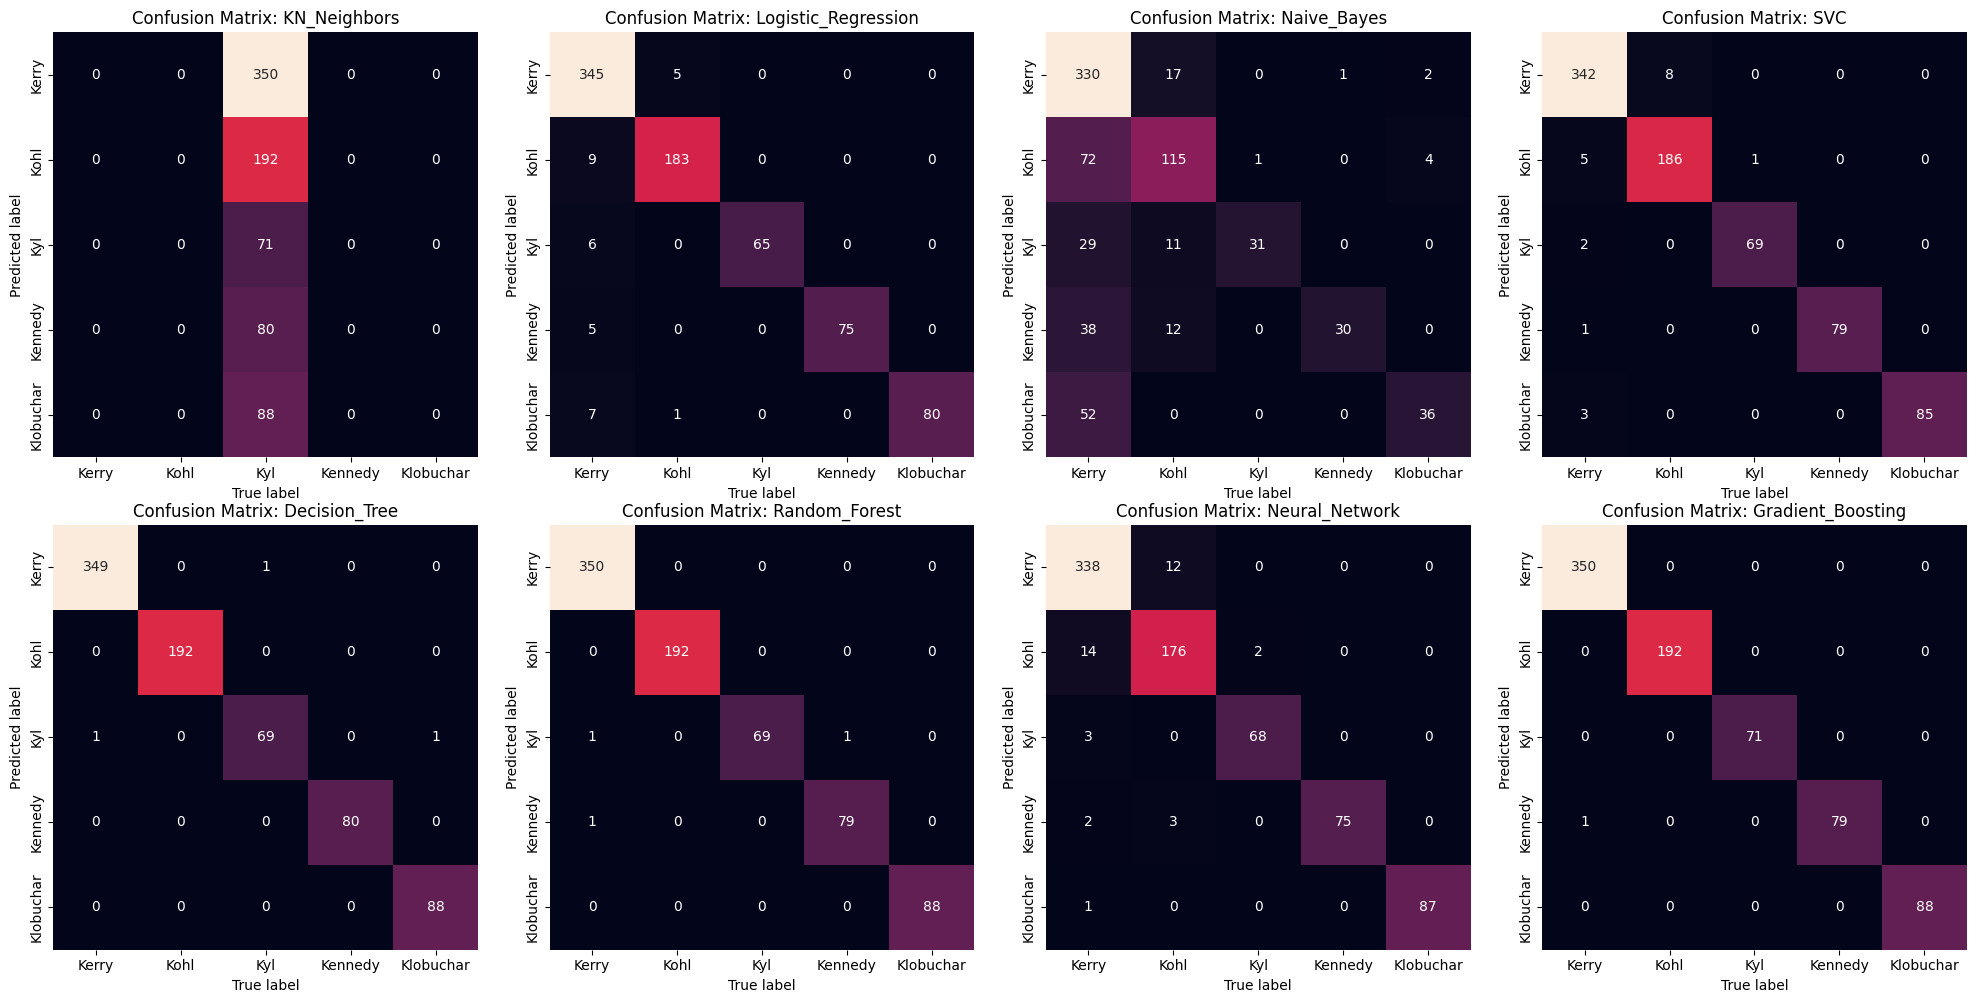

In [ ]:
final_performance_SenateLarge = main_classification(dfTraiLarge, dfTestLarge)

### For SenateLarge data
given the near-perfect scores across multiple metrics, the Gradient Boosting Classifier stands out as the most suitable model for the SenateLarge dataset, closely followed by the Decision Tree Classifier. The choice between these models could further depend on factors like training time, model interpretability, and computational resources, where Gradient Boosting might require more resources and time but offers slight improvements in performance.

## AdaBoost model

In [190]:
clfada = sklearn.ensemble.AdaBoostClassifier()

# Fit the classifier to the training data
clf.fit(np.stack(dfTrainSmall['vect'], axis=0), dfTrainSmall['category'])

# Evaluate the classifier on the test data
lucem_illud.evaluateClassifier(clf, dfTestSmall)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Obama,0.023392,0.972603,1.000000,0.968597,0.945205
Clinton,0.023392,0.972603,0.960784,0.960784,1.000000


Error Rate: Both categories have the same low error rate of approximately 0.023, indicating the classifier is making very few mistakes.
AUC (Area Under the ROC Curve): The AUC value is approximately 0.972 for both categories, which is very close to 1. This suggests an excellent ability to distinguish between the two categories.
Precision: For 'Obama', it is perfect at 1, meaning all instances classified as 'Obama' were correct. For 'Clinton', it's slightly lower at around 0.961, indicating that there are some false positives.
Average Precision: Similar to precision, this reflects the classifier's precision across different thresholds. It's very high for both categories.
Recall: For 'Obama', the recall is about 0.945, and for 'Clinton', it's perfect at 1. This means the classifier is catching all 'Clinton' instances and most 'Obama' instances

 The effectiveness of AdaBoost hinges on the combination of multiple 'weak learners' and the algorithm's parameters, including the number of estimators. It appears that the default settings of the AdaBoost classifier may not be optimized for all categories, which might explain the varied performance across different types of data. Adjustments to these parameters could potentially improve the classifier's performance where it currently lags.

 resource:https://www.machinelearningplus.com/machine-learning/introduction-to-adaboost/

## Other The artificial corpus part

### For Parenting dataset

The best performing model is Random Forest with an accuracy of 0.2

In [196]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import FunctionTransformer

In [197]:
classifiers = {
    "Logistic Regression": Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', LogisticRegression())
    ]),
    "Gaussian Naive Bayes": Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
        ('classifier', GaussianNB())
    ]),
    "SVM Linear Kernel": Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', SVC(kernel='linear', probability=True))
    ]),
    "K-Nearest Neighbors": Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', KNeighborsClassifier(5, weights='distance'))
    ]),
    "Decision Tree": Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ]),
    "Random Forest": Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', RandomForestClassifier())
    ]),
    "MLP Classifier": Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', MLPClassifier())
    ]),
    "Gradient Boosting": Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', GradientBoostingClassifier())
    ]),
}

In [ ]:
Parenting = pandas.read_csv('/content/drive/MyDrive/macss60000/week5/Parenting_submissions_control_text.csv', index_col=0)

In [ ]:
holdBackFraction = .2
Ptrain_data_df, Ptest_data_df = sklearn.model_selection.train_test_split(Parenting, test_size=holdBackFraction)

In [198]:
# Helper function to convert to dense
to_dense = lambda x: x.toarray()

def fit_logistic_regression(X, y):
    vect = TfidfVectorizer()
    clf = LogisticRegression()
    X_vect = vect.fit_transform(X)
    clf.fit(X_vect, y)
    return vect, clf

def fit_gaussian_nb(X, y):
    vect = TfidfVectorizer()
    clf = GaussianNB()
    X_vect = vect.fit_transform(X)
    X_dense = to_dense(X_vect)
    clf.fit(X_dense, y)
    return vect, clf

def fit_svm_linear(X, y):
    vect = TfidfVectorizer()
    clf = SVC(kernel='linear', probability=True)
    X_vect = vect.fit_transform(X)
    clf.fit(X_vect, y)
    return vect, clf

def fit_knn(X, y):
    vect = TfidfVectorizer()
    clf = KNeighborsClassifier(5, weights='distance')
    X_vect = vect.fit_transform(X)
    clf.fit(X_vect, y)
    return vect, clf

def fit_decision_tree(X, y):
    vect = TfidfVectorizer()
    clf = DecisionTreeClassifier()
    X_vect = vect.fit_transform(X)
    clf.fit(X_vect, y)
    return vect, clf

def fit_random_forest(X, y):
    vect = TfidfVectorizer()
    clf = RandomForestClassifier()
    X_vect = vect.fit_transform(X)
    clf.fit(X_vect, y)
    return vect, clf

def fit_mlp(X, y):
    vect = TfidfVectorizer()
    clf = MLPClassifier()
    X_vect = vect.fit_transform(X)
    clf.fit(X_vect, y)
    return vect, clf

def fit_gradient_boosting(X, y):
    vect = TfidfVectorizer()
    clf = GradientBoostingClassifier()
    X_vect = vect.fit_transform(X)
    clf.fit(X_vect, y)
    return vect, clf

# Dictionary mapping classifier names to their corresponding functions
classifiers = {
    "Logistic Regression": fit_logistic_regression,
    "Gaussian Naive Bayes": fit_gaussian_nb,
    "SVM Linear Kernel": fit_svm_linear,
    "K-Nearest Neighbors": fit_knn,
    "Decision Tree": fit_decision_tree,
    "Random Forest": fit_random_forest,
    "MLP Classifier": fit_mlp,
    "Gradient Boosting": fit_gradient_boosting,
}

In [199]:
best_model = None
best_accuracy = 0

# Train and evaluate the classifiers
for name, classifier_func in classifiers.items():
    print(f"Training and evaluating {name}")
    # Using the function to get the vectorizer and classifier
    tfidf, classifier = classifier_func(Ptrain_data_df['title'], Ptrain_data_df['score'])
    # Transform the test data using the trained vectorizer
    Ptest_data_tfidf = tfidf.transform(Ptest_data_df['title'])
    # If Gaussian Naive Bayes, convert to dense
    if name == 'Gaussian Naive Bayes':
        Ptest_data_tfidf = Ptest_data_tfidf.toarray()
    # Make predictions using the trained classifier
    predictions = classifier.predict(Ptest_data_tfidf)
    accuracy = accuracy_score(Ptest_data_df['score'], predictions)
    print(f"Accuracy of {name}: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = (name, classifier)  # Storing classifier instead of pipeline

print(f"The best performing model is {best_model[0]} with an accuracy of {best_accuracy}")


Training and evaluating Logistic Regression
Accuracy of Logistic Regression: 0.05
Training and evaluating Gaussian Naive Bayes
Accuracy of Gaussian Naive Bayes: 0.1
Training and evaluating SVM Linear Kernel
Accuracy of SVM Linear Kernel: 0.1
Training and evaluating K-Nearest Neighbors
Accuracy of K-Nearest Neighbors: 0.15
Training and evaluating Decision Tree
Accuracy of Decision Tree: 0.15
Training and evaluating Random Forest
Accuracy of Random Forest: 0.0
Training and evaluating MLP Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of MLP Classifier: 0.15
Training and evaluating Gradient Boosting
Accuracy of Gradient Boosting: 0.1
The best performing model is K-Nearest Neighbors with an accuracy of 0.15


### For YouShouldKnow_submissions_control_text dataset

The best performing model is MLP Classifier with an accuracy of 0.20

In [ ]:
You = pandas.read_csv('/content/drive/MyDrive/macss60000/week5/YouShouldKnow_submissions_control_text.csv', index_col=0)

In [ ]:
holdBackFraction = .2
Youtrain_data_df, Youtest_data_df = sklearn.model_selection.train_test_split(You, test_size=holdBackFraction)

In [ ]:
best_model = None
best_accuracy = 0

for name, classifier_func in classifiers.items():
    print(f"Training and evaluating {name}")
    tfidf, classifier = classifier_func(Ptrain_data_df['title'], Ptrain_data_df['score'])

    Ptest_data_tfidf = tfidf.transform(Ptest_data_df['title'])
    if name == 'Gaussian Naive Bayes':
        Ptest_data_tfidf = Ptest_data_tfidf.toarray()

    # Special handling for K-Nearest Neighbors if the test set is too small
    if name == 'K-Nearest Neighbors' and Ptest_data_df.shape[0] < classifier.n_neighbors:
        classifier.n_neighbors = Ptest_data_df.shape[0]

    predictions = classifier.predict(Ptest_data_tfidf)
    accuracy = accuracy_score(Ptest_data_df['score'], predictions)
    print(f"Accuracy of {name}: {accuracy:.2f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = (name, classifier)

if best_model is not None:
    print(f"The best performing model is {best_model[0]} with an accuracy of {best_accuracy:.2f}")
else:
    print("No best model was found.")

Training and evaluating Logistic Regression
Accuracy of Logistic Regression: 0.05
Training and evaluating Gaussian Naive Bayes
Accuracy of Gaussian Naive Bayes: 0.10
Training and evaluating SVM Linear Kernel
Accuracy of SVM Linear Kernel: 0.10
Training and evaluating K-Nearest Neighbors
Accuracy of K-Nearest Neighbors: 0.15
Training and evaluating Decision Tree
Accuracy of Decision Tree: 0.10
Training and evaluating Random Forest
Accuracy of Random Forest: 0.10
Training and evaluating MLP Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of MLP Classifier: 0.20
Training and evaluating Gradient Boosting
Accuracy of Gradient Boosting: 0.05
The best performing model is MLP Classifier with an accuracy of 0.20


### For YouShouldKnow_submissions_control_text dataset

The best performing model is MLP Classifier with an accuracy of 0.20

In [ ]:
antiwork = pandas.read_csv('/content/drive/MyDrive/macss60000/week5/antiwork_submissions_filtered_text.csv', index_col=0)

In [ ]:
holdBackFraction = .2
antiworktrain_data_df, antiworktest_data_df = sklearn.model_selection.train_test_split(antiwork, test_size=holdBackFraction)

In [ ]:
best_model = None
best_accuracy = 0

for name, classifier_func in classifiers.items():
    print(f"Training and evaluating {name}")
    tfidf, classifier = classifier_func(antiworktrain_data_df['title'], antiworktrain_data_df['score'])

    Ptest_data_tfidf = tfidf.transform(antiworktest_data_df['title'])
    if name == 'Gaussian Naive Bayes':
        Ptest_data_tfidf = Ptest_data_tfidf.toarray()

    # Special handling for K-Nearest Neighbors if the test set is too small
    if name == 'K-Nearest Neighbors' and antiworktest_data_df.shape[0] < classifier.n_neighbors:
        classifier.n_neighbors = antiworktest_data_df.shape[0]

    predictions = classifier.predict(Ptest_data_tfidf)
    accuracy = accuracy_score(antiworktest_data_df['score'], predictions)
    print(f"Accuracy of {name}: {accuracy:.2f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = (name, classifier)

if best_model is not None:
    print(f"The best performing model is {best_model[0]} with an accuracy of {best_accuracy:.2f}")
else:
    print("No best model was found.")

Training and evaluating Logistic Regression
Accuracy of Logistic Regression: 0.05
Training and evaluating Gaussian Naive Bayes
Accuracy of Gaussian Naive Bayes: 0.03
Training and evaluating SVM Linear Kernel
Accuracy of SVM Linear Kernel: 0.05
Training and evaluating K-Nearest Neighbors
Accuracy of K-Nearest Neighbors: 0.02
Training and evaluating Decision Tree
Accuracy of Decision Tree: 0.03
Training and evaluating Random Forest
Accuracy of Random Forest: 0.03
Training and evaluating MLP Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of MLP Classifier: 0.03
Training and evaluating Gradient Boosting
Accuracy of Gradient Boosting: 0.04
The best performing model is Logistic Regression with an accuracy of 0.05


### For depression dataset

The best performing model is MLP Classifier with an accuracy of 0.30

In [219]:
Life = pandas.read_csv('/content/drive/MyDrive/macss60000/week5/LifeProTips_submissions_control_text (1).csv', index_col=0)

In [220]:
holdBackFraction = .2
depressiontrain_data_df, depressiontest_data_df = sklearn.model_selection.train_test_split(Life, test_size=holdBackFraction)

In [ ]:
best_model = None
best_accuracy = 0

# Train and evaluate the classifiers
for name, classifier_func in classifiers.items():
    print(f"Training and evaluating {name}")
    # Using the function to get the vectorizer and classifier
    tfidf, classifier = classifier_func(depressiontrain_data_df['title'], depressiontrain_data_df['score'])
    # Transform the test data using the trained vectorizer
    Ptest_data_tfidf = tfidf.transform(depressiontest_data_df['title'])
    # If Gaussian Naive Bayes, convert to dense
    if name == 'Gaussian Naive Bayes':
        Ptest_data_tfidf = Ptest_data_tfidf.toarray()
    # Make predictions using the trained classifier
    predictions = classifier.predict(Ptest_data_tfidf)
    accuracy = accuracy_score(depressiontest_data_df['score'], predictions)
    print(f"Accuracy of {name}: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = (name, classifier)  # Storing classifier instead of pipeline

print(f"The best performing model is {best_model[0]} with an accuracy of {best_accuracy}")

Training and evaluating Logistic Regression
Accuracy of Logistic Regression: 0.14775725593667546
Training and evaluating Gaussian Naive Bayes
Accuracy of Gaussian Naive Bayes: 0.12137203166226913
Training and evaluating SVM Linear Kernel
Accuracy of SVM Linear Kernel: 0.1503957783641161
Training and evaluating K-Nearest Neighbors
Accuracy of K-Nearest Neighbors: 0.0712401055408971
Training and evaluating Decision Tree
Accuracy of Decision Tree: 0.07387862796833773
Training and evaluating Random Forest
Accuracy of Random Forest: 0.158311345646438
Training and evaluating MLP Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of MLP Classifier: 0.12137203166226913
Training and evaluating Gradient Boosting


### For depression dataset

The best performing model is Logistic Regression with an accuracy of 0.3333333333333333

In [203]:
getdisciplined = pandas.read_csv('/content/drive/MyDrive/macss60000/week5/getdisciplined_submissions_control_text.csv', index_col=0)

In [204]:
holdBackFraction = .2
gettrain_data_df, gettest_data_df = sklearn.model_selection.train_test_split(getdisciplined, test_size=holdBackFraction)

In [205]:
best_model = None
best_accuracy = 0

# Train and evaluate the classifiers
for name, classifier_func in classifiers.items():
    print(f"Training and evaluating {name}")
    # Using the function to get the vectorizer and classifier
    tfidf, classifier = classifier_func(gettrain_data_df['title'], gettrain_data_df['score'])
    # Transform the test data using the trained vectorizer
    Ptest_data_tfidf = tfidf.transform(gettest_data_df['title'])
    # If Gaussian Naive Bayes, convert to dense
    if name == 'Gaussian Naive Bayes':
        Ptest_data_tfidf = Ptest_data_tfidf.toarray()
    # Make predictions using the trained classifier
    predictions = classifier.predict(Ptest_data_tfidf)
    accuracy = accuracy_score(gettest_data_df['score'], predictions)
    print(f"Accuracy of {name}: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = (name, classifier)  # Storing classifier instead of pipeline

print(f"The best performing model is {best_model[0]} with an accuracy of {best_accuracy}")

Training and evaluating Logistic Regression
Accuracy of Logistic Regression: 0.3333333333333333
Training and evaluating Gaussian Naive Bayes
Accuracy of Gaussian Naive Bayes: 0.0
Training and evaluating SVM Linear Kernel
Accuracy of SVM Linear Kernel: 0.3333333333333333
Training and evaluating K-Nearest Neighbors
Accuracy of K-Nearest Neighbors: 0.0
Training and evaluating Decision Tree
Accuracy of Decision Tree: 0.3333333333333333
Training and evaluating Random Forest
Accuracy of Random Forest: 0.0
Training and evaluating MLP Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of MLP Classifier: 0.0
Training and evaluating Gradient Boosting
Accuracy of Gradient Boosting: 0.0
The best performing model is Logistic Regression with an accuracy of 0.3333333333333333


### For Fitness dataset

The best performing model is SVM Linear Kernel with an accuracy of 0.38461538461538464

In [206]:
Fitness = pandas.read_csv('/content/drive/MyDrive/macss60000/week5/Fitness_submissions_control_text.csv', index_col=0)

In [207]:
holdBackFraction = .2
jobstrain_data_df, jobstest_data_df = sklearn.model_selection.train_test_split(Fitness, test_size=holdBackFraction)

In [208]:
best_model = None
best_accuracy = 0

# Train and evaluate the classifiers
for name, classifier_func in classifiers.items():
    print(f"Training and evaluating {name}")
    # Using the function to get the vectorizer and classifier
    tfidf, classifier = classifier_func(jobstrain_data_df['title'], jobstrain_data_df['score'])
    # Transform the test data using the trained vectorizer
    Ptest_data_tfidf = tfidf.transform(jobstest_data_df['title'])
    # If Gaussian Naive Bayes, convert to dense
    if name == 'Gaussian Naive Bayes':
        Ptest_data_tfidf = Ptest_data_tfidf.toarray()
    # Make predictions using the trained classifier
    predictions = classifier.predict(Ptest_data_tfidf)
    accuracy = accuracy_score(jobstest_data_df['score'], predictions)
    print(f"Accuracy of {name}: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = (name, classifier)  # Storing classifier instead of pipeline

print(f"The best performing model is {best_model[0]} with an accuracy of {best_accuracy}")

Training and evaluating Logistic Regression
Accuracy of Logistic Regression: 0.34615384615384615
Training and evaluating Gaussian Naive Bayes
Accuracy of Gaussian Naive Bayes: 0.2692307692307692
Training and evaluating SVM Linear Kernel
Accuracy of SVM Linear Kernel: 0.38461538461538464
Training and evaluating K-Nearest Neighbors
Accuracy of K-Nearest Neighbors: 0.23076923076923078
Training and evaluating Decision Tree
Accuracy of Decision Tree: 0.2692307692307692
Training and evaluating Random Forest
Accuracy of Random Forest: 0.34615384615384615
Training and evaluating MLP Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of MLP Classifier: 0.2692307692307692
Training and evaluating Gradient Boosting
Accuracy of Gradient Boosting: 0.38461538461538464
The best performing model is SVM Linear Kernel with an accuracy of 0.38461538461538464


### For mentalhealth dataset

The best performing model is SVM Linear Kernel with an accuracy of 0.46621621621621623

In [210]:
mentalhealth = pandas.read_csv('/content/drive/MyDrive/macss60000/week5/mentalhealth_submissions_filtered_text.csv', index_col=0)

In [211]:
holdBackFraction = .2
Mtrain_data_df, Mtest_data_df = sklearn.model_selection.train_test_split(mentalhealth, test_size=holdBackFraction)

In [212]:
best_model = None
best_accuracy = 0

# Train and evaluate the classifiers
for name, classifier_func in classifiers.items():
    print(f"Training and evaluating {name}")
    # Using the function to get the vectorizer and classifier
    tfidf, classifier = classifier_func(Mtrain_data_df['title'], Mtrain_data_df['score'])
    # Transform the test data using the trained vectorizer
    Ptest_data_tfidf = tfidf.transform(Mtest_data_df['title'])
    # If Gaussian Naive Bayes, convert to dense
    if name == 'Gaussian Naive Bayes':
        Ptest_data_tfidf = Ptest_data_tfidf.toarray()
    # Make predictions using the trained classifier
    predictions = classifier.predict(Ptest_data_tfidf)
    accuracy = accuracy_score(Mtest_data_df['score'], predictions)
    print(f"Accuracy of {name}: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = (name, classifier)  # Storing classifier instead of pipeline

print(f"The best performing model is {best_model[0]} with an accuracy of {best_accuracy}")

Training and evaluating Logistic Regression
Accuracy of Logistic Regression: 0.4594594594594595
Training and evaluating Gaussian Naive Bayes
Accuracy of Gaussian Naive Bayes: 0.23873873873873874
Training and evaluating SVM Linear Kernel
Accuracy of SVM Linear Kernel: 0.46621621621621623
Training and evaluating K-Nearest Neighbors
Accuracy of K-Nearest Neighbors: 0.3783783783783784
Training and evaluating Decision Tree
Accuracy of Decision Tree: 0.3310810810810811
Training and evaluating Random Forest
Accuracy of Random Forest: 0.42792792792792794
Training and evaluating MLP Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of MLP Classifier: 0.34459459459459457
Training and evaluating Gradient Boosting
Accuracy of Gradient Boosting: 0.35135135135135137
The best performing model is SVM Linear Kernel with an accuracy of 0.46621621621621623


### For socialanxiety dataset

The best performing model is SVM Linear Kernel with an accuracy of 0.2857142857142857

In [213]:
socialanxiety = pandas.read_csv('/content/drive/MyDrive/macss60000/week5/socialanxiety_submissions_filtered_text.csv', index_col=0)

In [214]:
socialtrain_data_df, socialtest_data_df = sklearn.model_selection.train_test_split(socialanxiety, test_size=holdBackFraction)

In [215]:
best_model = None
best_accuracy = 0

# Train and evaluate the classifiers
for name, classifier_func in classifiers.items():
    print(f"Training and evaluating {name}")
    # Using the function to get the vectorizer and classifier
    tfidf, classifier = classifier_func(socialtrain_data_df['title'], socialtrain_data_df['score'])
    # Transform the test data using the trained vectorizer
    Ptest_data_tfidf = tfidf.transform(socialtest_data_df['title'])
    # If Gaussian Naive Bayes, convert to dense
    if name == 'Gaussian Naive Bayes':
        Ptest_data_tfidf = Ptest_data_tfidf.toarray()
    # Make predictions using the trained classifier
    predictions = classifier.predict(Ptest_data_tfidf)
    accuracy = accuracy_score(socialtest_data_df['score'], predictions)
    print(f"Accuracy of {name}: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = (name, classifier)  # Storing classifier instead of pipeline

print(f"The best performing model is {best_model[0]} with an accuracy of {best_accuracy}")

Training and evaluating Logistic Regression
Accuracy of Logistic Regression: 0.2571428571428571
Training and evaluating Gaussian Naive Bayes
Accuracy of Gaussian Naive Bayes: 0.17142857142857143
Training and evaluating SVM Linear Kernel
Accuracy of SVM Linear Kernel: 0.2857142857142857
Training and evaluating K-Nearest Neighbors
Accuracy of K-Nearest Neighbors: 0.17142857142857143
Training and evaluating Decision Tree
Accuracy of Decision Tree: 0.17142857142857143
Training and evaluating Random Forest
Accuracy of Random Forest: 0.11428571428571428
Training and evaluating MLP Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of MLP Classifier: 0.17142857142857143
Training and evaluating Gradient Boosting
Accuracy of Gradient Boosting: 0.14285714285714285
The best performing model is SVM Linear Kernel with an accuracy of 0.2857142857142857


### For writing dataset

The best performing model is Gaussian Naive Bayes with an accuracy of 0.05

In [216]:
writing = pandas.read_csv('/content/drive/MyDrive/macss60000/week5/writing_submissions_control_text.csv', index_col=0)

In [217]:
wtrain_data_df, wtest_data_df = sklearn.model_selection.train_test_split(writing, test_size=holdBackFraction)

In [218]:
best_model = None
best_accuracy = 0

# Train and evaluate the classifiers
for name, classifier_func in classifiers.items():
    print(f"Training and evaluating {name}")
    # Using the function to get the vectorizer and classifier
    tfidf, classifier = classifier_func(wtrain_data_df['title'], wtrain_data_df['score'])
    # Transform the test data using the trained vectorizer
    Ptest_data_tfidf = tfidf.transform(wtest_data_df['title'])
    # If Gaussian Naive Bayes, convert to dense
    if name == 'Gaussian Naive Bayes':
        Ptest_data_tfidf = Ptest_data_tfidf.toarray()
    # Make predictions using the trained classifier
    predictions = classifier.predict(Ptest_data_tfidf)
    accuracy = accuracy_score(wtest_data_df['score'], predictions)
    print(f"Accuracy of {name}: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = (name, classifier)  # Storing classifier instead of pipeline

print(f"The best performing model is {best_model[0]} with an accuracy of {best_accuracy}")

Training and evaluating Logistic Regression
Accuracy of Logistic Regression: 0.0
Training and evaluating Gaussian Naive Bayes
Accuracy of Gaussian Naive Bayes: 0.05
Training and evaluating SVM Linear Kernel
Accuracy of SVM Linear Kernel: 0.0
Training and evaluating K-Nearest Neighbors
Accuracy of K-Nearest Neighbors: 0.05
Training and evaluating Decision Tree
Accuracy of Decision Tree: 0.05
Training and evaluating Random Forest
Accuracy of Random Forest: 0.05
Training and evaluating MLP Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of MLP Classifier: 0.0
Training and evaluating Gradient Boosting
Accuracy of Gradient Boosting: 0.05
The best performing model is Gaussian Naive Bayes with an accuracy of 0.05


# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest?

In [ ]:
ObamaClintonReleases = pandas.read_csv('/content/drive/MyDrive/macss60000/week5/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame.

In [ ]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [ ]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [ ]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [ ]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Let's split the data into training data and testing data.

In [ ]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [ ]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents.

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean?

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1.

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform.

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [ ]:
TFVects.shape

(1367, 11347)

We can save this in the dataframe to make things easier

In [ ]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [ ]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [ ]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

<ipython-input-85-c9d2b7441e78>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")
<ipython-input-85-c9d2b7441e78>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")


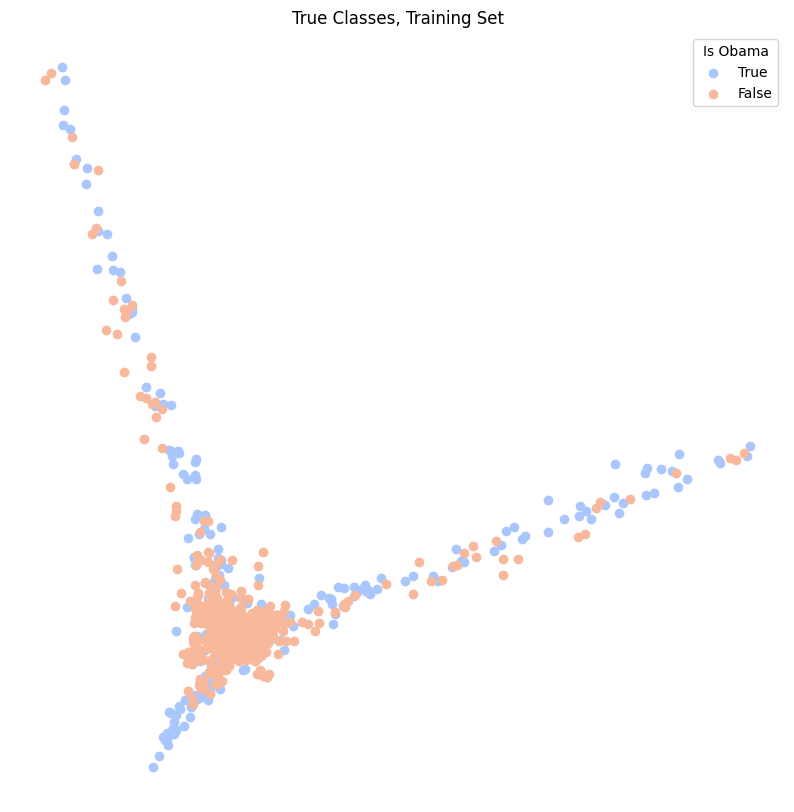

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")

ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

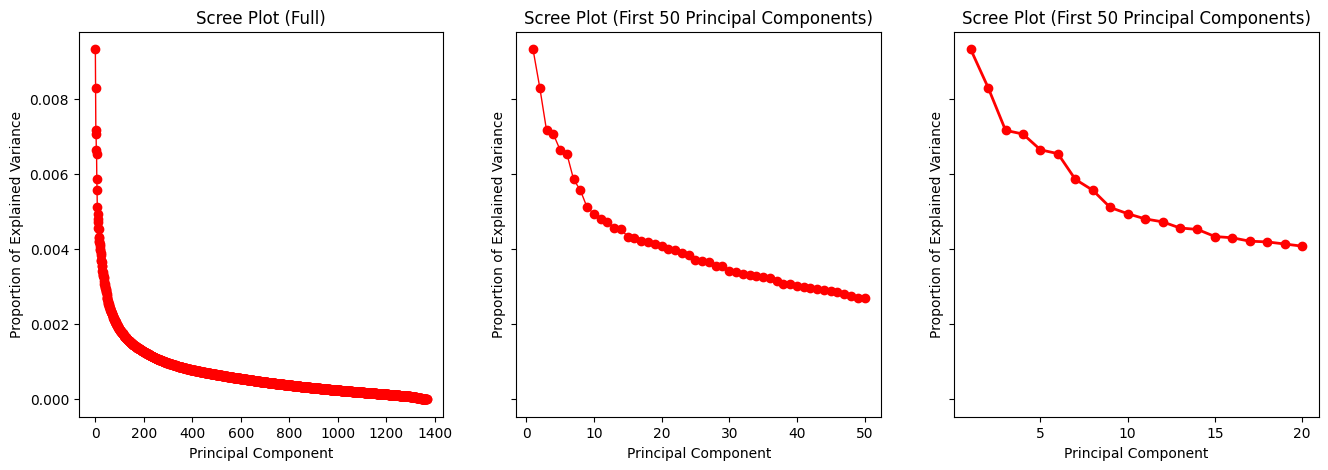

In [ ]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [ ]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [ ]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [ ]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6847110460863204

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [ ]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.7076023391812866

Slightly poorer. How about using more dimensions (40)?

In [ ]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7425018288222385
Testing:
0.7339181286549707


Or still more (100)?

In [ ]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8339429407461595
Testing:
0.7777777777777778


Or even more (200)!

In [ ]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.866861741038771
Testing:
0.7865497076023392


This is becoming ridiculous (400)!

In [ ]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9107534747622531
Testing:
0.8216374269005848


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [ ]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9685442574981712


Train the model using training data, and then test it on the testing data.

In [ ]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8245614035087719


In [ ]:
len(test_data_df['vect'])

342

In [ ]:
len(test_data_df['category'])

342

81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and uncoded (i.e., data you didn't code by hand but want to use your model on) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [ ]:
burnout_balance = '/content/drive/MyDrive/macss60000/week5/burnout_balance.csv'  # Adjusted path for the local environment

# Read the CSV file into a DataFrame
Ba_df = pd.read_csv(burnout_balance)

In [ ]:
Ba_df

,cleaned_review,score,num_comments,word_count,title_word_count,Burnout evaluation,created_utc_converted,Burnout_evaluation
0,my nine month old absolutely loves it when I s...,2,7,53,7,0.0,2020-05-19 22:44:10,0.0
1,Hi So for a little background information I ...,2,1,247,11,1.0,2021-12-19 02:52:37,1.0
2,When I am mad or very sad I have the urge to ...,3,2,38,7,0.0,2022-09-19 11:35:02,0.0
3,Basically I am getting distracted because I am...,2,2,125,9,1.0,2022-07-12 03:55:16,1.0
4,I wasn t sure how to flair this so let me know...,3,1,279,16,1.0,2018-08-17 06:03:21,1.0
...,...,...,...,...,...,...,...,...
5501,I can never keep enough business cards in my w...,0,0,46,19,0.0,2013-07-24 17:10:59,0.0
5502,So recently i have began to notice more and m...,3,3,121,2,1.0,2018-10-01 04:33:28,1.0
5503,I am an artist I feel like am is such a loo...,1,0,324,9,1.0,2022-08-27 21:25:25,1.0
5504,Why do you think that is Could it have to do ...,0,15,36,14,0.0,2015-03-10 18:31:34,0.0


In [ ]:
Ba_df['category'] = [s == 1.0 for s in Ba_df['Burnout_evaluation']]

In [ ]:
Ba_df['tokenized_text'] = Ba_df['cleaned_review'].apply(lambda x: lucem_illud.word_tokenize(x))
Ba_df['normalized_text'] = Ba_df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
Ba_df

,cleaned_review,score,num_comments,word_count,title_word_count,Burnout evaluation,created_utc_converted,Burnout_evaluation,category,tokenized_text,normalized_text
0,my nine month old absolutely loves it when I s...,2,7,53,7,0.0,2020-05-19 22:44:10,0.0,False,"[my, nine, month, old, absolutely, loves, it, ...","[month, old, absolutely, love, sing, try, sing..."
1,Hi So for a little background information I ...,2,1,247,11,1.0,2021-12-19 02:52:37,1.0,True,"[Hi, So, for, a, little, background, informati...","[hi, little, background, information, ve, grea..."
2,When I am mad or very sad I have the urge to ...,3,2,38,7,0.0,2022-09-19 11:35:02,0.0,False,"[When, I, am, mad, or, very, sad, I, have, the...","[mad, sad, urge, improve, life, experience, gl..."
3,Basically I am getting distracted because I am...,2,2,125,9,1.0,2022-07-12 03:55:16,1.0,True,"[Basically, I, am, getting, distracted, becaus...","[basically, get, distract, stress, work, turn,..."
4,I wasn t sure how to flair this so let me know...,3,1,279,16,1.0,2018-08-17 06:03:21,1.0,True,"[I, wasn, t, sure, how, to, flair, this, so, l...","[wasn, t, sure, flair, let, know, fit, well, f..."
...,...,...,...,...,...,...,...,...,...,...,...
5501,I can never keep enough business cards in my w...,0,0,46,19,0.0,2013-07-24 17:10:59,0.0,False,"[I, can, never, keep, enough, business, cards,...","[business, card, wallet, pack, card, binder, c..."
5502,So recently i have began to notice more and m...,3,3,121,2,1.0,2018-10-01 04:33:28,1.0,True,"[So, recently, i, have, began, to, notice, mor...","[recently, begin, notice, tend, help, love, pu..."
5503,I am an artist I feel like am is such a loo...,1,0,324,9,1.0,2022-08-27 21:25:25,1.0,True,"[I, am, an, artist, I, feel, like, am, is, suc...","[artist, feel, like, loose, term, hardly, draw..."
5504,Why do you think that is Could it have to do ...,0,15,36,14,0.0,2015-03-10 18:31:34,0.0,False,"[Why, do, you, think, that, is, Could, it, hav...","[think, lower, barrier, today, barrier, decade..."


In [ ]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(Ba_df, test_size=holdBackFraction)

In [ ]:
print(len(train_data_df))
print(len(test_data_df))

4404
1102


In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['cleaned_review'])

In [ ]:
TFVects

<4404x11350 sparse matrix of type '<class 'numpy.float64'>'
	with 129064 stored elements in Compressed Sparse Row format>

In [ ]:
TFVects.shape

(4404, 11350)

In [ ]:
TFVectorizer

TfidfVectorizer(max_df=100, min_df=2, stop_words='english')

In [ ]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [ ]:
train_data_df

,cleaned_review,score,num_comments,word_count,title_word_count,Burnout evaluation,created_utc_converted,Burnout_evaluation,category,tokenized_text,normalized_text,vect
1911,Napkins in the glove compartment tire pressur...,2,20,24,8,0.0,2017-01-30 00:28:20,0.0,False,"[Napkins, in, the, glove, compartment, tire, p...","[napkin, glove, compartment, tire, pressure, g...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3776,I have been applying to to countless positions...,1,0,74,7,1.0,2014-08-26 19:19:24,1.0,True,"[I, have, been, applying, to, to, countless, p...","[apply, countless, position, year, net, interv...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
865,Honestly I bought my blanket because I prefer ...,3,11,29,34,0.0,2020-03-03 19:19:24,0.0,False,"[Honestly, I, bought, my, blanket, because, I,...","[honestly, buy, blanket, prefer, heavy, cotton...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
820,Invest in yourself now so that you can reap t...,0,27,47,20,0.0,2020-04-21 08:40:30,0.0,False,"[Invest, in, yourself, now, so, that, you, can...","[invest, reap, benefit, later, likely, chance,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3069,I am a doctor in Amerikkka and let me tell you...,508,44,664,5,1.0,2021-12-20 14:07:23,1.0,True,"[I, am, a, doctor, in, Amerikkka, and, let, me...","[doctor, amerikkka, let, tell, corrupt, system...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4000,Watch your favorite funny movie Even if you ...,1,1,29,6,0.0,2015-06-13 23:49:09,0.0,False,"[Watch, your, favorite, funny, movie, Even, if...","[watch, favorite, funny, movie, feel, like, la...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3802,Hi there has anyone suffered from Burnout at ...,1,1,9,9,1.0,2022-01-23 13:24:09,1.0,True,"[Hi, there, has, anyone, suffered, from, Burno...","[hi, suffer, burnout]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5176,It took years of concerted purposeful nea...,7,5,1135,4,1.0,2022-04-02 02:57:54,1.0,True,"[It, took, years, of, concerted, purposeful, n...","[take, year, concerted, purposeful, nearly, un...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4713,Hey friends Can I just vent for a minute ...,129,16,814,12,1.0,2022-04-20 08:01:13,1.0,True,"[Hey, friends, Can, I, just, vent, for, a, min...","[hey, friend, vent, minute, respiratory, thera...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [ ]:
train_data_df['pca'] = [r for r in reduced_data]

In [ ]:
train_data_df

,cleaned_review,score,num_comments,word_count,title_word_count,Burnout evaluation,created_utc_converted,Burnout_evaluation,category,tokenized_text,normalized_text,vect,pca
1911,Napkins in the glove compartment tire pressur...,2,20,24,8,0.0,2017-01-30 00:28:20,0.0,False,"[Napkins, in, the, glove, compartment, tire, p...","[napkin, glove, compartment, tire, pressure, g...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.06564081213156402, -0.024867369253315414, -..."
3776,I have been applying to to countless positions...,1,0,74,7,1.0,2014-08-26 19:19:24,1.0,True,"[I, have, been, applying, to, to, countless, p...","[apply, countless, position, year, net, interv...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0031819983873544702, 0.001977737150607263,..."
865,Honestly I bought my blanket because I prefer ...,3,11,29,34,0.0,2020-03-03 19:19:24,0.0,False,"[Honestly, I, bought, my, blanket, because, I,...","[honestly, buy, blanket, prefer, heavy, cotton...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05386204393683361, -0.003870087413215928, -..."
820,Invest in yourself now so that you can reap t...,0,27,47,20,0.0,2020-04-21 08:40:30,0.0,False,"[Invest, in, yourself, now, so, that, you, can...","[invest, reap, benefit, later, likely, chance,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.037147003941060026, 0.0034851184915666777, ..."
3069,I am a doctor in Amerikkka and let me tell you...,508,44,664,5,1.0,2021-12-20 14:07:23,1.0,True,"[I, am, a, doctor, in, Amerikkka, and, let, me...","[doctor, amerikkka, let, tell, corrupt, system...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0744033042983869, -0.009420039478364924, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4000,Watch your favorite funny movie Even if you ...,1,1,29,6,0.0,2015-06-13 23:49:09,0.0,False,"[Watch, your, favorite, funny, movie, Even, if...","[watch, favorite, funny, movie, feel, like, la...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.04948206745237636, 0.03000301739387905, -0...."
3802,Hi there has anyone suffered from Burnout at ...,1,1,9,9,1.0,2022-01-23 13:24:09,1.0,True,"[Hi, there, has, anyone, suffered, from, Burno...","[hi, suffer, burnout]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02159194680625058, -0.00193167893985954, -0..."
5176,It took years of concerted purposeful nea...,7,5,1135,4,1.0,2022-04-02 02:57:54,1.0,True,"[It, took, years, of, concerted, purposeful, n...","[take, year, concerted, purposeful, nearly, un...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.10361621924601966, -0.009894518770266172, ..."
4713,Hey friends Can I just vent for a minute ...,129,16,814,12,1.0,2022-04-20 08:01:13,1.0,True,"[Hey, friends, Can, I, just, vent, for, a, min...","[hey, friend, vent, minute, respiratory, thera...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.09943890044320956, -0.008729613381786856, ..."


In [ ]:
train_data_df['pca'].shape

(4404,)

<ipython-input-82-247b02f1d673>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")
<ipython-input-82-247b02f1d673>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")


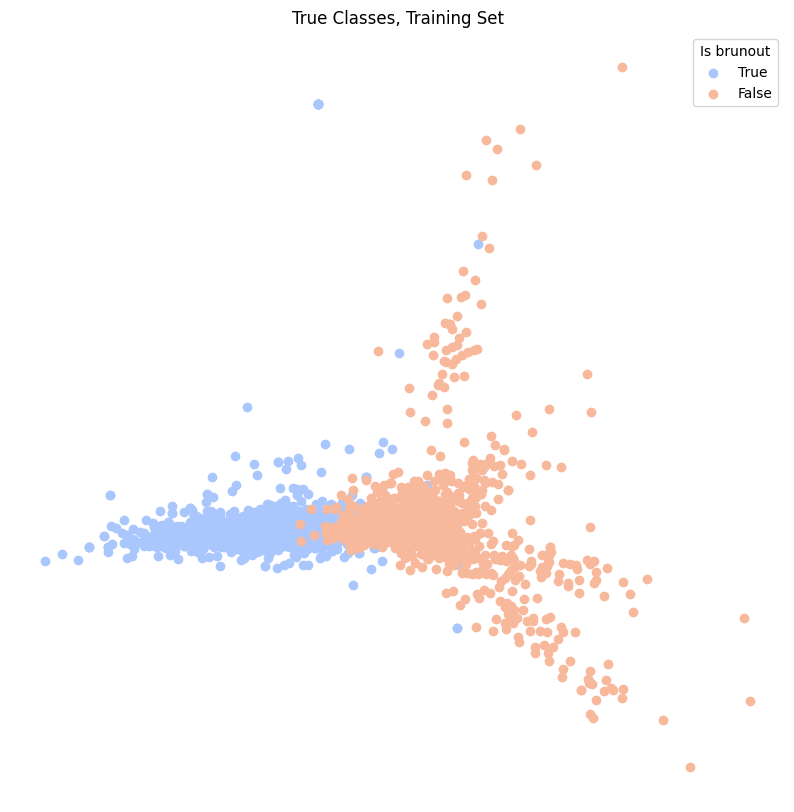

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")

ax.legend(loc = 'upper right', title = 'Is brunout')
plt.title('True Classes, Training Set')
plt.show()

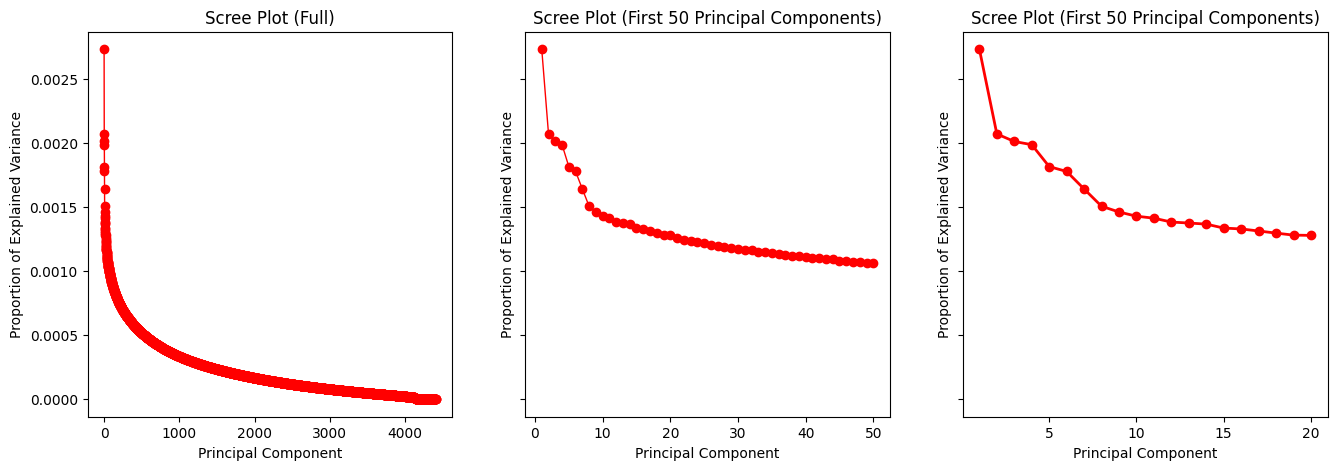

In [ ]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [ ]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

In [ ]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

In [ ]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.9239327883742052

In [ ]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['cleaned_review'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.925589836660617

In [ ]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.9280199818346957
Testing:
0.9310344827586207


In [ ]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.9302906448683016
Testing:
0.9310344827586207


In [ ]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.9361943687556766
Testing:
0.9319419237749547


In [ ]:
logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

LogisticRegression()

In [ ]:
train_data_df['pca_reduced_200']

1911    [0.06564081213156402, -0.024867369253315414, -...
3776    [-0.0031819983873544702, 0.001977737150607263,...
865     [0.05386204393683361, -0.003870087413215928, -...
820     [0.037147003941060026, 0.0034851184915666777, ...
3069    [-0.0744033042983869, -0.009420039478364924, 0...
                              ...                        
4000    [0.04948206745237636, 0.03000301739387905, -0....
3802    [0.02159194680625058, -0.00193167893985954, -0...
5176    [-0.10361621924601966, -0.009894518770266172, ...
4713    [-0.09943890044320956, -0.008729613381786856, ...
4300    [-0.04297963651404116, -0.001368700732679163, ...
Name: pca_reduced_200, Length: 4404, dtype: object

In [ ]:
test_data_df['pca_reduced_200']

3280    [-0.08761087712138704, -0.016230599563784066, ...
1936    [-0.03278888073285283, 0.004227245218016122, -...
3846    [0.019491802546601142, 0.021049810690431593, 0...
469     [0.0002269088561204021, -0.004850287114017618,...
930     [-0.03236676192714928, 0.0042316535105619, -0....
                              ...                        
720     [-0.032482237491339834, -0.005106399687192802,...
209     [-0.02415150488263394, 0.001951510610605508, 0...
2043    [-0.063999380277775, -0.0061503387116081144, 0...
2516    [0.02728213810208242, -0.005178417957391887, -...
1754    [0.02501735162624239, 0.0017143283549026188, -...
Name: pca_reduced_200, Length: 1102, dtype: object

In [ ]:
test_data_df['category']

3280     True
1936     True
3846     True
469      True
930      True
        ...  
720      True
209     False
2043     True
2516    False
1754    False
Name: category, Length: 1102, dtype: bool

In [ ]:
# Create a new DataFrame for evaluation that includes a 'vect' column with the correct 2D shape
test_data_for_evaluation = test_data_df.copy()
test_data_for_evaluation['vect'] = list(test_data_df['pca_reduced_200'])

# Now call evaluateClassifier with the new DataFrame
lucem_illud.evaluateClassifier(logistic, test_data_for_evaluation)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.068058,0.932354,0.908932,0.891232,0.957565
True,0.068058,0.932354,0.956685,0.915037,0.907143


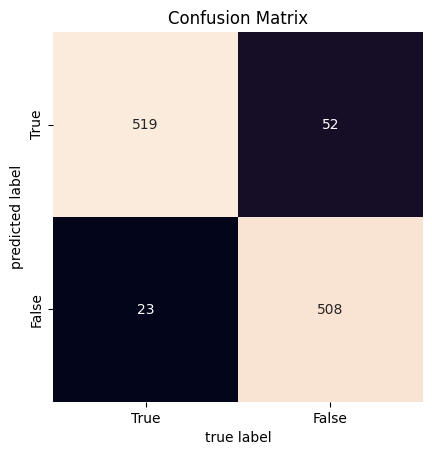

In [ ]:
lucem_illud.plotConfusionMatrix(logistic, test_data_for_evaluation)

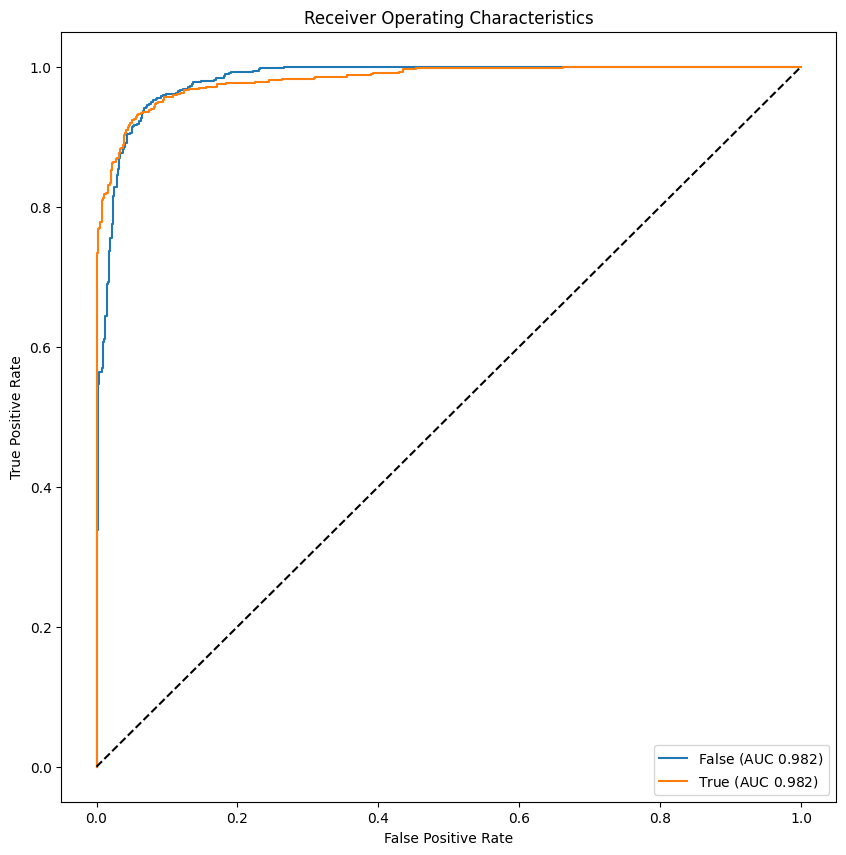

In [ ]:
lucem_illud.plotMultiROC(logistic, test_data_for_evaluation)

In [ ]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9475476839237057
Testing:
0.9401088929219601


In [ ]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9836512261580381


In [ ]:
test_data_df

,cleaned_review,score,num_comments,word_count,title_word_count,Burnout evaluation,created_utc_converted,Burnout_evaluation,category,tokenized_text,normalized_text,vect,pca,pca_reduced_10,pca_reduced_40,pca_reduced_100,pca_reduced_200,pca_reduced_400
3280,Hi all I would appreciate any thoughts on my ...,2,2,474,9,1.0,2021-01-06 19:40:20,1.0,True,"[Hi, all, I, would, appreciate, any, thoughts,...","[hi, appreciate, thought, current, situation, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.08761087712138704, -0.016230599563784066, ...","[-0.08761087712138704, -0.016230599563784066, ...","[-0.08761087712138704, -0.016230599563784066, ...","[-0.08761087712138704, -0.016230599563784066, ...","[-0.08761087712138704, -0.016230599563784066, ...","[-0.08761087712138704, -0.016230599563784066, ..."
1936,I work for a company that is always wondering ...,10,3,326,10,1.0,2022-02-08 23:48:36,1.0,True,"[I, work, for, a, company, that, is, always, w...","[work, company, wonder, people, currency, cont...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03278888073285283, 0.004227245218016122, -...","[-0.03278888073285283, 0.004227245218016122, -...","[-0.03278888073285283, 0.004227245218016122, -...","[-0.03278888073285283, 0.004227245218016122, -...","[-0.03278888073285283, 0.004227245218016122, -...","[-0.03278888073285283, 0.004227245218016122, -..."
3846,I found this video fascinating because it des...,5,9,47,6,1.0,2022-11-10 22:44:04,1.0,True,"[I, found, this, video, fascinating, because, ...","[find, video, fascinating, describe, workplace...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.019491802546601142, 0.021049810690431593, 0...","[0.019491802546601142, 0.021049810690431593, 0...","[0.019491802546601142, 0.021049810690431593, 0...","[0.019491802546601142, 0.021049810690431593, 0...","[0.019491802546601142, 0.021049810690431593, 0...","[0.019491802546601142, 0.021049810690431593, 0..."
469,I just got a new job at a Carwash and I alread...,12,18,95,17,1.0,2022-04-21 16:22:20,1.0,True,"[I, just, got, a, new, job, at, a, Carwash, an...","[get, new, job, carwash, want, quit, s, hour, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0002269088561204021, -0.004850287114017618,...","[0.0002269088561204021, -0.004850287114017618,...","[0.0002269088561204021, -0.004850287114017618,...","[0.0002269088561204021, -0.004850287114017618,...","[0.0002269088561204021, -0.004850287114017618,...","[0.0002269088561204021, -0.004850287114017618,..."
930,I have been with my employer for years Sin...,30,24,267,11,1.0,2022-01-04 03:00:10,1.0,True,"[I, have, been, with, my, employer, for, years...","[employer, year, start, major, promotion, high...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03236676192714928, 0.0042316535105619, -0....","[-0.03236676192714928, 0.0042316535105619, -0....","[-0.03236676192714928, 0.0042316535105619, -0....","[-0.03236676192714928, 0.0042316535105619, -0....","[-0.03236676192714928, 0.0042316535105619, -0....","[-0.03236676192714928, 0.0042316535105619, -0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,Multitasking is a real bitch It use to be tha...,14,1,134,1,1.0,2021-04-12 13:17:48,1.0,True,"[Multitasking, is, a, real, bitch, It, use, to...","[multitaske, real, bitch, use, job, require, d...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.032482237491339834, -0.005106399687192802,...","[-0.032482237491339834, -0.005106399687192802,...","[-0.032482237491339834, -0.005106399687192802,...","[-0.032482237491339834, -0.005106399687192802,...","[-0.032482237491339834, -0.005106399687192802,...","[-0.032482237491339834, -0.005106399687192802,..."
209,Contrary to popular culture Love is not all p...,0,5,48,26,0.0,2016-01-16 14:22:45,0.0,False,"[Contrary, to, popular, culture, Love, is, not...","[contrary, popular, culture, love, passion, ti...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.02415150488263394, 0.00

In [ ]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.9446460980036298


In [ ]:
lucem_illud.evaluateClassifier(logistic_l1, train_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.016349,0.983601,0.972185,0.970272,0.995929
True,0.016349,0.983601,0.995792,0.981491,0.971272


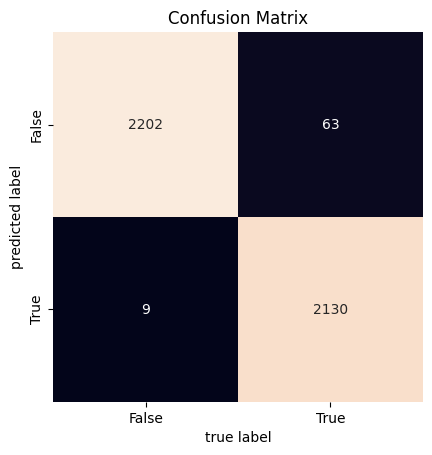

In [ ]:
lucem_illud.plotConfusionMatrix(logistic_l1, train_data_df)

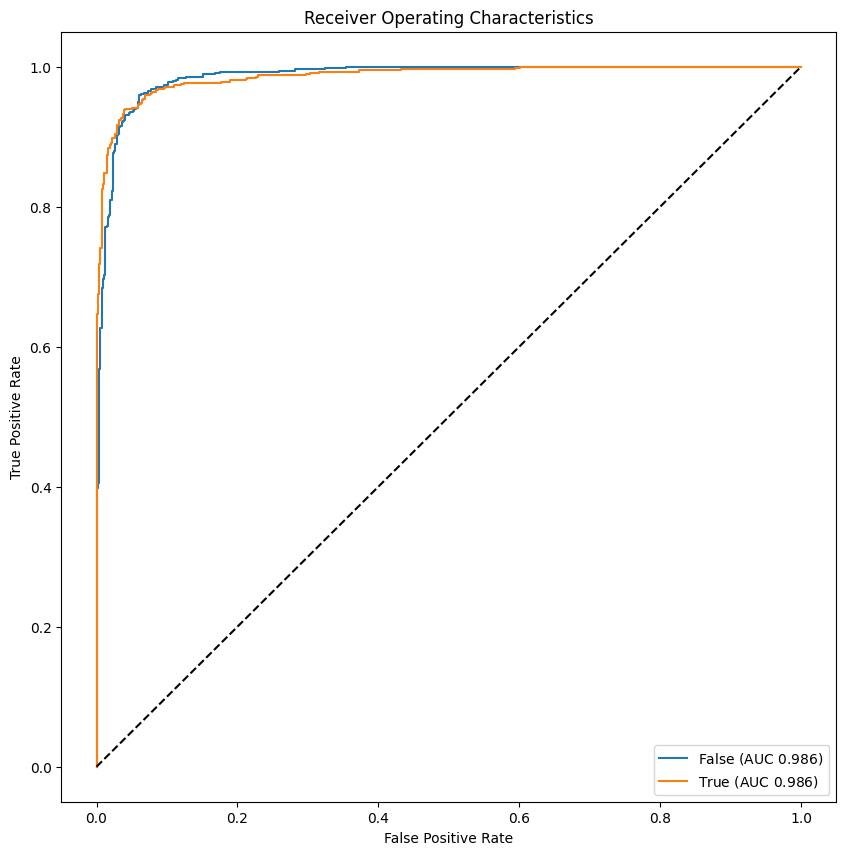

In [ ]:
lucem_illud.plotMultiROC(logistic_l1, test_data_df)

"Based on this analysis and the results, it is suggested that L1 regularization logistic regression outperforms logistic regression without regularization, even when the latter is applied to PCA-reduced dimensions. This conclusion is supported by the evidence from the confusion matrix, precision, recall, F-measure, and AUC.



- The Logistic Regression models with varying levels of PCA reduction (10, 40, 100, 200, 400 components) show high training accuracy, often exceeding 92%. This suggests that the models fit the training data well. However, the most critical assessment is how they perform on the test data, which also shows high accuracy, indicating that the models generalize well.

- The confusion matrices for the classifiers show high numbers of true positives and true negatives. The number of false positives and false negatives is relatively low, indicating good classification performance.

- The Receiver Operating Characteristic (ROC) curves are close to the top-left corner of the plot, which implies a good trade-off between true positive rate and false positive rate. The Area Under the Curve (AUC) scores are very high (close to 1), which is excellent for classifier performance.
Scree Plot:

- So it seems reasonable to expect that the distribution of the uncoded data is similar to that of the training and testing data.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

/usr/local/lib/python3.10/dist-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


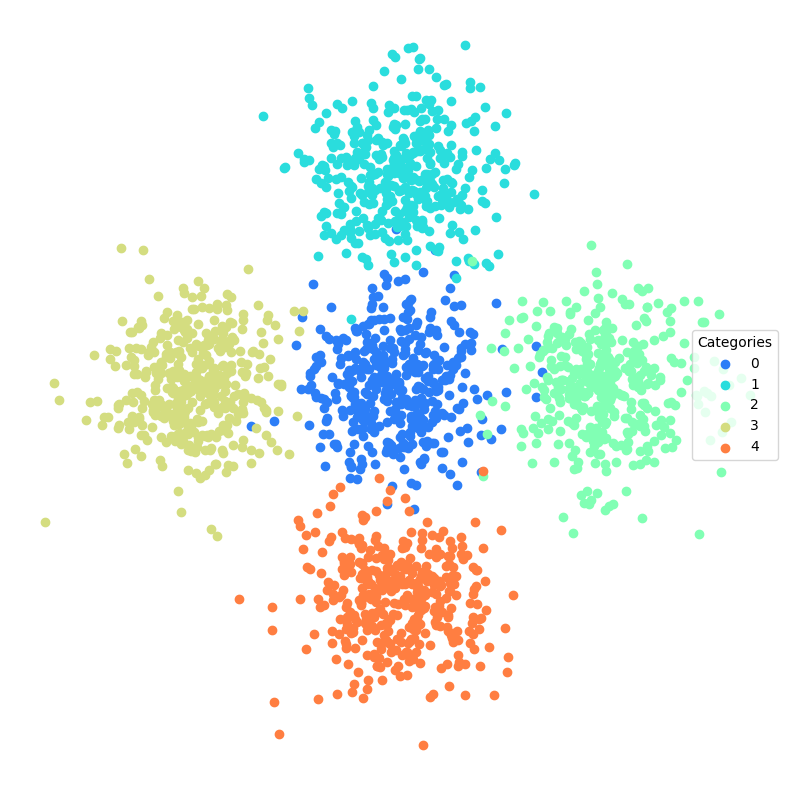

In [ ]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

In [ ]:
multiBlobs

<function __main__.multiBlobs(noise=0, numPerCategory=500, centers=5)>

In [ ]:
blobs_df

,vect,category
0,"[-0.15503343332243458, -1.3630734172570733]",0
1,"[3.5529382815510155, -0.22021998409862992]",2
2,"[2.8396979961760067, 0.4508616964033972]",2
3,"[-0.534925856459389, 6.127091945161187]",1
4,"[4.932417263366918, 0.19165901539514438]",2
...,...,...
2495,"[-4.899653758665109, 0.5432646915585522]",3
2496,"[-1.7954949309626693, 3.5581241790425615]",1
2497,"[7.823298205293961, 1.7004022930931417]",2
2498,"[-6.407863164092179, -0.8097774261128537]",3


In [ ]:
df_exampleTree_train

,vect,category
1677,"[-0.6318080385585501, 2.32217295767455]",0
51,"[-0.2472094751073562, 5.1115688949352]",1
1435,"[-0.5265520898219362, -5.0447571692986175]",4
1483,"[-6.983852396266189, 0.888527733569587]",3
2099,"[-5.923316269590637, -0.30973116299270137]",3
...,...,...
978,"[0.8775682861527571, -5.2553218482383075]",4
1736,"[1.123624830534026, -0.6641504493158761]",0
89,"[5.750013485498133, 0.8371282425996249]",2
2314,"[2.4324328896275027, 3.1103961549604606]",1


Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification:

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


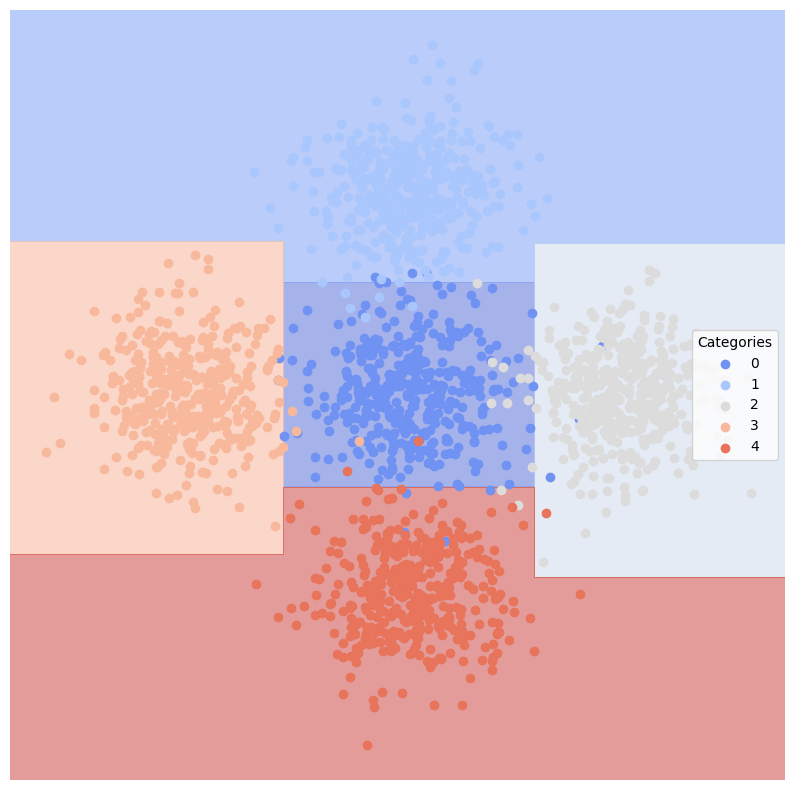

In [ ]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [ ]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.034,0.957265,0.899083,0.859212,0.942308
1,0.012,0.981108,0.969697,0.946312,0.969697
2,0.004,0.988372,1.000000,0.980744,0.976744
3,0.010,0.979507,0.990099,0.960018,0.961538
4,0.008,0.988110,0.981308,0.966966,0.981308


Lets look at accuracy:

In [ ]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.966

In [ ]:
df_exampleTree_test['vect']

588     [0.18098360245178768, -3.4510142227037006]
640      [-4.6675636060160315, 0.3370229431485234]
2009     [-4.469143437356832, -1.0432950582478258]
269       [1.0326688792670145, 4.8718348669547344]
957        [1.1842847921975597, 5.363882015628051]
                           ...                    
1459      [-1.552459104988806, 0.8824965135980961]
699      [0.15388368331943353, -4.047058265519457]
1047     [-0.8912584402639944, -4.793707492865559]
1743    [-0.8208258508421133, 0.48458741087624446]
221         [2.440514953358569, -6.51348400778976]
Name: vect, Length: 500, dtype: object

What happens if we trim the tree?

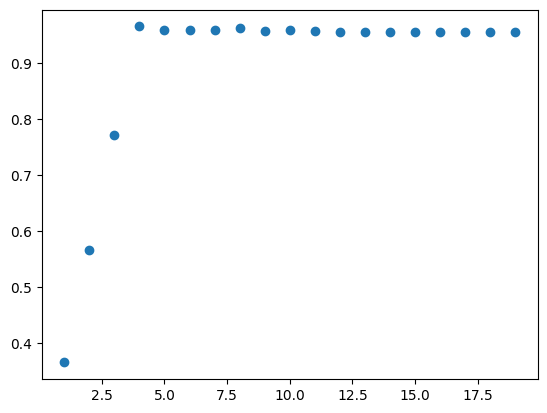

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


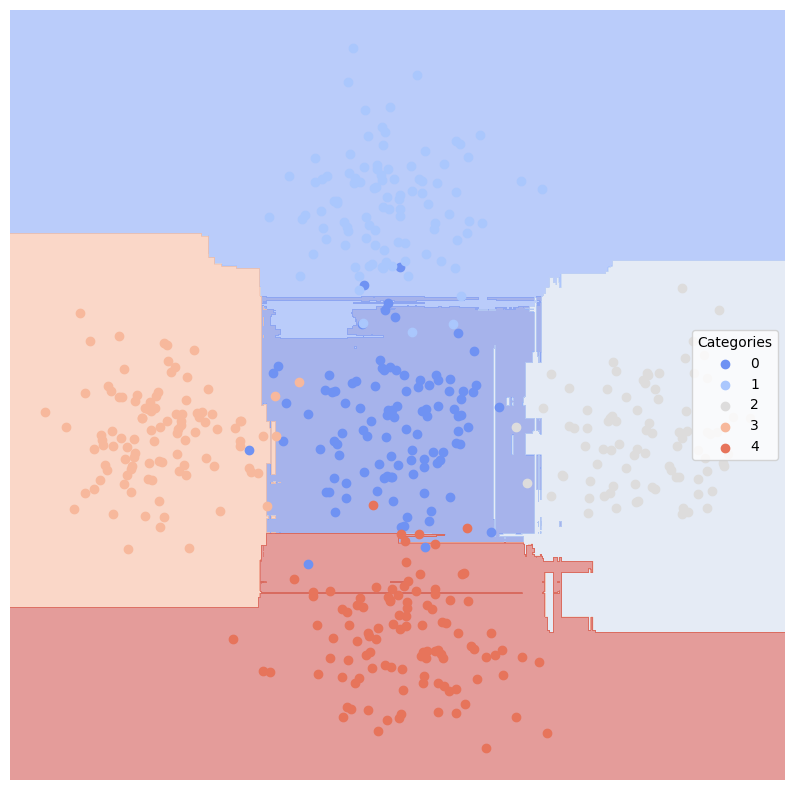

In [ ]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [ ]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.038,0.954740,0.882883,0.843947,0.942308
1,0.012,0.981108,0.969697,0.946312,0.969697
2,0.004,0.988372,1.000000,0.980744,0.976744
3,0.010,0.979507,0.990099,0.960018,0.961538
4,0.012,0.978764,0.980952,0.952281,0.962617


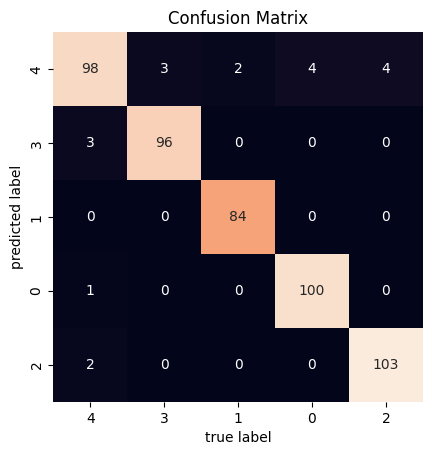

In [ ]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [ ]:
train_data_df

,cleaned_review,score,num_comments,word_count,title_word_count,Burnout evaluation,created_utc_converted,Burnout_evaluation,category,tokenized_text,normalized_text,vect,pca,pca_reduced_10,pca_reduced_40,pca_reduced_100,pca_reduced_200,pca_reduced_400
4694,Hi so it is as the title says but even as i ...,1,3,999,10,1.0,2021-01-29 07:32:31,1.0,True,"[Hi, so, it, is, as, the, title, says, but, ev...","[hi, title, say, write, sure, word, break, sen...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.11095627618378917, -0.02059781868940108, 0...","[-0.11095627618378917, -0.02059781868940108, 0...","[-0.11095627618378917, -0.02059781868940108, 0...","[-0.11095627618378917, -0.02059781868940108, 0...","[-0.11095627618378917, -0.02059781868940108, 0...","[-0.11095627618378917, -0.02059781868940108, 0..."
4310,Hey gang Here is a brief not so brief ...,0,3,30,14,0.0,2021-02-22 02:55:10,0.0,False,"[Hey, gang, Here, is, a, brief, not, so, brief...","[hey, gang, brief, brief, discussion, genesis,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.031522367382614026, 0.04832819878730696, 0....","[0.031522367382614026, 0.04832819878730696, 0....","[0.031522367382614026, 0.04832819878730696, 0....","[0.031522367382614026, 0.04832819878730696, 0....","[0.031522367382614026, 0.04832819878730696, 0....","[0.031522367382614026, 0.04832819878730696, 0...."
2281,I have been doing this for years and was surpr...,12060,388,46,19,0.0,2020-02-03 09:29:01,0.0,False,"[I, have, been, doing, this, for, years, and, ...","[year, surprised, long, positive, balance, use...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01873998270220891, 0.003468722354385016, -0...","[0.01873998270220891, 0.003468722354385016, -0...","[0.01873998270220891, 0.003468722354385016, -0...","[0.01873998270220891, 0.003468722354385016, -0...","[0.01873998270220891, 0.003468722354385016, -0...","[0.01873998270220891, 0.003468722354385016, -0..."
4956,I am seriously considering going into web desi...,5,1,122,12,1.0,2014-04-17 16:50:50,1.0,True,"[I, am, seriously, considering, going, into, w...","[seriously, consider, go, web, design, instead...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0406712194971956, 0.009812281998530372, -0...","[-0.0406712194971956, 0.009812281998530372, -0...","[-0.0406712194971956, 0.009812281998530372, -0...","[-0.0406712194971956, 0.009812281998530372, -0...","[-0.0406712194971956, 0.009812281998530372, -0...","[-0.0406712194971956, 0.009812281998530372, -0..."
3397,I started out as a manager I have worked for ...,9,2,481,4,1.0,2021-12-05 10:52:27,1.0,True,"[I, started, out, as, a, manager, I, have, wor...","[start, manager, work, company, year, retail, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.05899827313202081, -0.009095575480243026, ...","[-0.05899827313202081, -0.009095575480243026, ...","[-0.05899827313202081, -0.009095575480243026, ...","[-0.05899827313202081, -0.009095575480243026, ...","[-0.05899827313202081, -0.009095575480243026, ...","[-0.05899827313202081, -0.009095575480243026, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,I read Mortimer Adler is book about reading bo...,0,18,37,7,0.0,2015-01-06 19:46:42,0.0,False,"[I, read, Mortimer, Adler, is, book, about, re...","[read, mortimer, adler, book, read, book, skim...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0816628683361962, 0.4292939044254843, 0.182...","[0.0816628683361962, 0.4292939044254843, 0.182...","[0.0816628683361962, 0.4292939044254843, 0.182...","[0.0816628683361962, 0.4292939044254843, 0.182...","[0.0816628683361962, 0.4292939044254843, 0.182...","[0.0816628683361962, 0.4292939044254843, 0.182..."
5280,Hi everyone So I have been working at the sa...,1,1,264,6,1.0,2016-05-26 11:58:01,1.0,True,"[Hi, everyone, So, I, have, been, working, at,...","[hi, work, place, june, start, learn, achieve,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.05688651764236546, -0

In [ ]:
train_data_df['category']

1429    False
4370     True
5194     True
2522    False
91      False
        ...  
1177     True
3033    False
4739    False
2609    False
2405    False
Name: category, Length: 4404, dtype: bool

In [ ]:
clf_tree1 = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree1.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

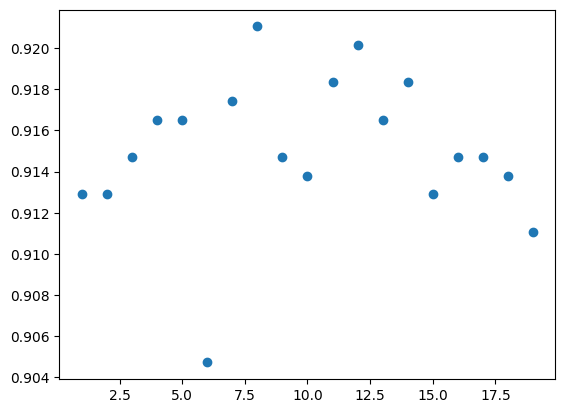

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])
    score = sklearn.metrics.accuracy_score(test_data_df['category'], tree2.predict(np.stack(test_data_df['pca_reduced_10'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

In [ ]:
fit_and_evaluate(clf_tree1, train_data_df, test_data_df)

Evaluation metrics for DecisionTreeClassifier:
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False        0.41833  0.574003   0.549116           0.548973  0.996435
True         0.41833  0.574003   0.976190           0.564478  0.151571


(DecisionTreeClassifier(max_depth=4, random_state=0),
           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 False        0.41833  0.574003   0.549116           0.548973  0.996435
 True         0.41833  0.574003   0.976190           0.564478  0.151571)

In [ ]:
train_data_df['pca_reduced_2'] = train_data_df['pca'].apply(lambda x: x[:2])
test_data_df['pca_reduced_2'] = test_data_df['pca'].apply(lambda x: x[:2])

clf_tree1.fit(np.stack(train_data_df['pca_reduced_2'], axis=0), train_data_df['category'])

print("Training:")
print(clf_tree1.score(np.stack(train_data_df['pca_reduced_2'], axis=0), train_data_df['category']))
print("Testing:")
print(clf_tree1.score(np.stack(test_data_df['pca_reduced_2'], axis=0), test_data_df['category']))

Training:
0.9291553133514986
Testing:
0.9283121597096189


In [ ]:
fit_and_evaluate(clf_tree1, train_data_df, test_data_df)

Evaluation metrics for DecisionTreeClassifier:
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
False       0.417423  0.58333   0.544643           0.544560  0.998182
True        0.417423  0.58333   0.989362           0.583201  0.168478


(DecisionTreeClassifier(max_depth=4, random_state=0),
           Error_Rate      AUC  Precision  Average_Precision    Recall
 Category                                                             
 False       0.417423  0.58333   0.544643           0.544560  0.998182
 True        0.417423  0.58333   0.989362           0.583201  0.168478)

In [ ]:
from matplotlib.colors import ListedColormap

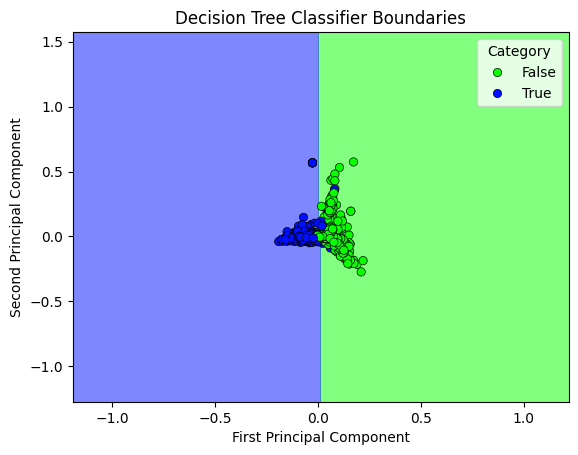

In [ ]:
# Assuming pca_reduced_10 is already a 2-dimensional representation
X_train = np.stack(train_data_df['pca_reduced_2'].values, axis=0)
y_train = train_data_df['category'].values

# Create a decision tree classifier
clf_tree1 = DecisionTreeClassifier(max_depth=4, random_state=0)
clf_tree1.fit(X_train, y_train)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Predict on the mesh grid
Z = clf_tree1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
palette = sns.color_palette("hsv", len(np.unique(y_train)))
plt.contourf(xx, yy, Z, alpha=0.5, cmap=ListedColormap(palette))

# Plot the training points
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, palette=palette, edgecolor='k')

# Set the plot title and labels
plt.title('Decision Tree Classifier Boundaries')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(title='Category')
plt.show()

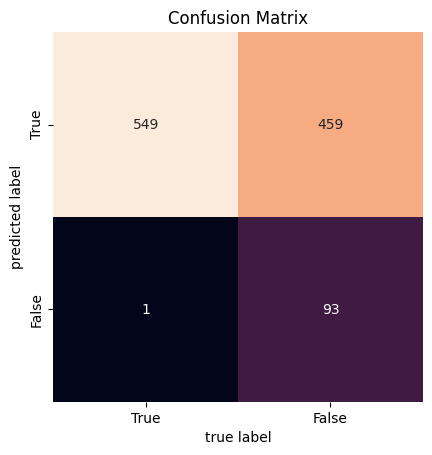

In [ ]:
lucem_illud.plotConfusionMatrix(clf_tree1, test_data_df)

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(train_data_df['pca_reduced_2'], axis=0), train_data_df['category']) #Fit the bagged classifier

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

In [ ]:
train_data_df['pca_reduced_2']

4694     [-0.11095627618378917, -0.02059781868940108]
4310      [0.031522367382614026, 0.04832819878730696]
2281      [0.01873998270220891, 0.003468722354385016]
4956      [-0.0406712194971956, 0.009812281998530372]
3397    [-0.05899827313202081, -0.009095575480243026]
                            ...                      
1092         [0.0816628683361962, 0.4292939044254843]
5280     [-0.05688651764236546, -0.00911861964328771]
2077        [0.1252340323620968, -0.1062254365278139]
867     [0.008390534240704047, -0.004843777372313117]
2938     [-0.02304673543701257, -0.01323089719228864]
Name: pca_reduced_2, Length: 4404, dtype: object

In [ ]:
def plotregions(clf, df, h=.01):
    # Check if the data is already 2D
    if df['vect'].apply(lambda x: len(x)).unique() == [2]:
        # Data is already 2D, so we use it as-is
        transformedDF = df
    else:
        # Perform PCA to reduce to 2 dimensions
        pca = sklearn.decomposition.PCA(n_components=2)
        reduced_data = pca.fit_transform(np.stack(df['vect'], axis=0))
        transformedDF = pandas.DataFrame({'vect': [r for r in reduced_data], 'category': df['category']})

    catsMap = {c: i for i, c in enumerate(np.unique(df['category']))}

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis('off')
    pallet = seaborn.color_palette(palette='coolwarm', n_colors=len(set(transformedDF['category'])))

    # Create a meshgrid for plotting
    reduced_data = np.stack(transformedDF['vect'], axis=0)
    xx, yy = np.meshgrid(np.arange(1.1 * reduced_data[:, 0].min(), 1.1 * reduced_data[:, 0].max(), h),
                         np.arange(1.1 * reduced_data[:, 1].min(), 1.1 * reduced_data[:, 1].max(), h))

    # Predict on the meshgrid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.vectorize(lambda x: catsMap[x])(Z)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)

    # Plot the data points
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(transformedDF[transformedDF['category'] == cat]['vect'])
        ax.scatter(a[:, 0], a[:, 1], c=pallet[catsMap[cat]], label=cat)

    ax.legend(loc='center right', title='Categories')
    plt.show()
    plt.close()

<ipython-input-305-b2cf151750ac>:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:, 0], a[:, 1], c=pallet[catsMap[cat]], label=cat)


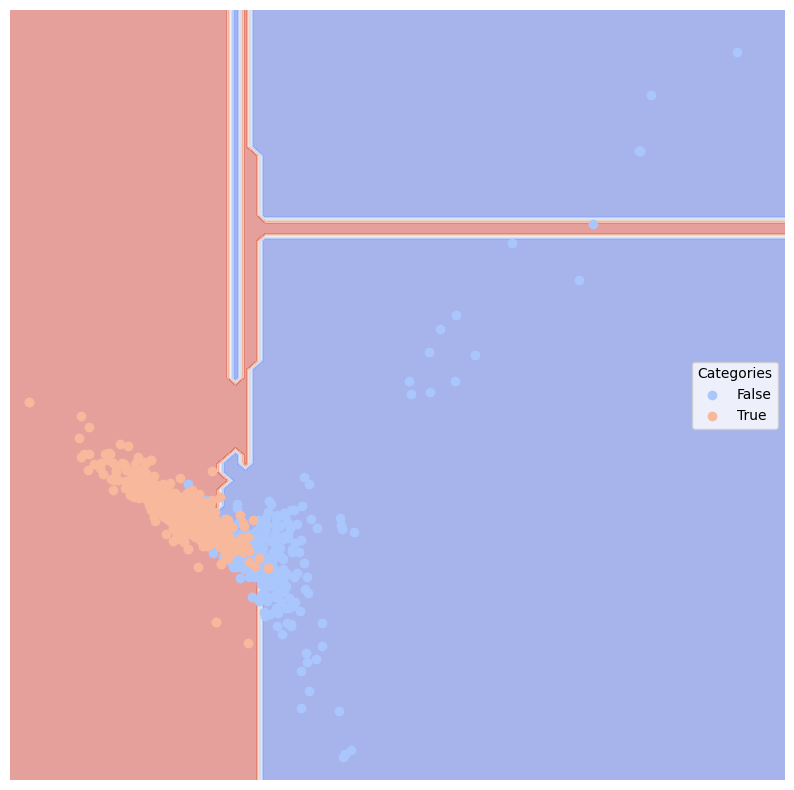

In [ ]:
plotregions(bag, test_data_df)

In [ ]:
fit_and_evaluate(bag, train_data_df, test_data_df)

Evaluation metrics for BaggingClassifier:
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False       0.206897  0.793452   0.711286           0.708200  0.985455
True        0.206897  0.793452   0.976471           0.786935  0.601449


(BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                   max_samples=0.8, n_estimators=100, random_state=1),
           Error_Rate       AUC  Precision  Average_Precision    Recall
 Category                                                              
 False       0.206897  0.793452   0.711286           0.708200  0.985455
 True        0.206897  0.793452   0.976471           0.786935  0.601449)

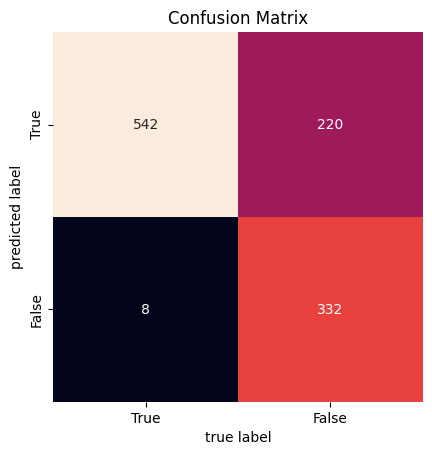

In [ ]:
lucem_illud.plotConfusionMatrix(bag, test_data_df)

### 

- Ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone. They are especially good at reducing the overfitting problem of the decision tree.
- The ensemble classifier is performing better than the single decision tree classifier. 
- It exhibits a more balanced classification ability as evidenced by the confusion matrices and has created more complex decision boundaries which could allow for better generalization to new data
- It does so by creating a more robust model that generalizes better to unseen data, thereby improving prediction accuracy and stability.

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data.

In [ ]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus. # replace path if on Colab
newsgroups.target_names #Possible categories, i.e., the newsgroups

target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, well, ..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[m, sorry, read, commandment]"


Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
sci.space,0.724158,0.500401,0.275421,0.275421,1.000000
soc.religion.christian,0.281069,0.500000,0.000000,0.281069,0.000000
talk.religion.misc,0.173635,0.500000,0.000000,0.173635,0.000000
comp.graphics,0.269454,0.501075,1.000000,0.271605,0.002151


And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.27610208816705334


Let's produce another confusion matrix:

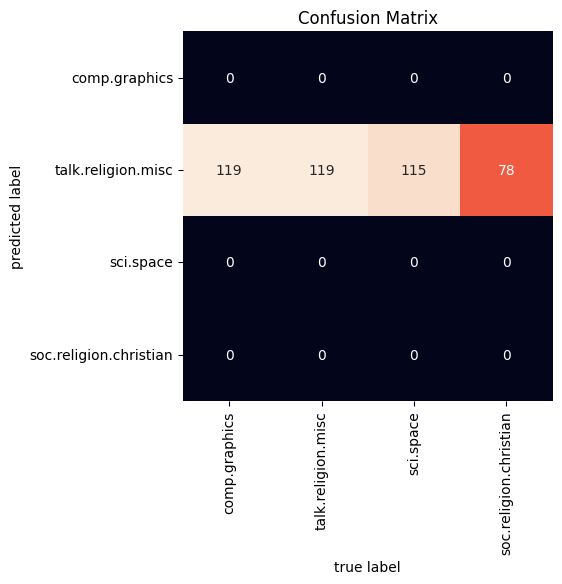

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
# lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [ ]:
Ba_df

,cleaned_review,score,num_comments,word_count,title_word_count,Burnout evaluation,created_utc_converted,Burnout_evaluation,category,tokenized_text,normalized_text
0,my nine month old absolutely loves it when I s...,2,7,53,7,0.0,2020-05-19 22:44:10,0.0,False,"[my, nine, month, old, absolutely, loves, it, ...","[month, old, absolutely, love, sing, try, sing..."
1,Hi So for a little background information I ...,2,1,247,11,1.0,2021-12-19 02:52:37,1.0,True,"[Hi, So, for, a, little, background, informati...","[hi, little, background, information, ve, grea..."
2,When I am mad or very sad I have the urge to ...,3,2,38,7,0.0,2022-09-19 11:35:02,0.0,False,"[When, I, am, mad, or, very, sad, I, have, the...","[mad, sad, urge, improve, life, experience, gl..."
3,Basically I am getting distracted because I am...,2,2,125,9,1.0,2022-07-12 03:55:16,1.0,True,"[Basically, I, am, getting, distracted, becaus...","[basically, get, distract, stress, work, turn,..."
4,I wasn t sure how to flair this so let me know...,3,1,279,16,1.0,2018-08-17 06:03:21,1.0,True,"[I, wasn, t, sure, how, to, flair, this, so, l...","[wasn, t, sure, flair, let, know, fit, well, f..."
...,...,...,...,...,...,...,...,...,...,...,...
5501,I can never keep enough business cards in my w...,0,0,46,19,0.0,2013-07-24 17:10:59,0.0,False,"[I, can, never, keep, enough, business, cards,...","[business, card, wallet, pack, card, binder, c..."
5502,So recently i have began to notice more and m...,3,3,121,2,1.0,2018-10-01 04:33:28,1.0,True,"[So, recently, i, have, began, to, notice, mor...","[recently, begin, notice, tend, help, love, pu..."
5503,I am an artist I feel like am is such a loo...,1,0,324,9,1.0,2022-08-27 21:25:25,1.0,True,"[I, am, an, artist, I, feel, like, am, is, suc...","[artist, feel, like, loose, term, hardly, draw..."
5504,Why do you think that is Could it have to do ...,0,15,36,14,0.0,2015-03-10 18:31:34,0.0,False,"[Why, do, you, think, that, is, Could, it, hav...","[think, lower, barrier, today, barrier, decade..."


In [ ]:
Ba_df_one = Ba_df[0:100]
Ba_df_one

,cleaned_review,score,num_comments,word_count,title_word_count,Burnout evaluation,created_utc_converted,Burnout_evaluation,category,tokenized_text,normalized_text
0,my nine month old absolutely loves it when I s...,2,7,53,7,0.0,2020-05-19 22:44:10,0.0,False,"[my, nine, month, old, absolutely, loves, it, ...","[month, old, absolutely, love, sing, try, sing..."
1,Hi So for a little background information I ...,2,1,247,11,1.0,2021-12-19 02:52:37,1.0,True,"[Hi, So, for, a, little, background, informati...","[hi, little, background, information, ve, grea..."
2,When I am mad or very sad I have the urge to ...,3,2,38,7,0.0,2022-09-19 11:35:02,0.0,False,"[When, I, am, mad, or, very, sad, I, have, the...","[mad, sad, urge, improve, life, experience, gl..."
3,Basically I am getting distracted because I am...,2,2,125,9,1.0,2022-07-12 03:55:16,1.0,True,"[Basically, I, am, getting, distracted, becaus...","[basically, get, distract, stress, work, turn,..."
4,I wasn t sure how to flair this so let me know...,3,1,279,16,1.0,2018-08-17 06:03:21,1.0,True,"[I, wasn, t, sure, how, to, flair, this, so, l...","[wasn, t, sure, flair, let, know, fit, well, f..."
...,...,...,...,...,...,...,...,...,...,...,...
95,I m have been an iron work construction s...,1,2,98,6,1.0,2021-03-02 05:31:34,1.0,True,"[I, m, have, been, an, iron, work, constructio...","[m, iron, work, construction, small, company, ..."
96,I work with seniors who are low income have m...,10,3,232,11,1.0,2019-05-29 21:32:20,1.0,True,"[I, work, with, seniors, who, are, low, income...","[work, senior, low, income, mental, illness, d..."
97,I want a workout that I can do every day witho...,1,3,49,7,0.0,2013-09-03 17:05:09,0.0,False,"[I, want, a, workout, that, I, can, do, every,...","[want, workout, day, harm, body, start, strong..."
98,My AGM decided to schedule me days in a row ...,20,9,384,6,1.0,2022-04-03 18:26:16,1.0,True,"[My, AGM, decided, to, schedule, me, days, in,...","[agm, decide, schedule, day, row, way, pay, pe..."


In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(Ba_df_one, test_size=holdBackFraction)

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['cleaned_review'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
train_ng_df['cleaned_review']

51    People who walk around with their mouths hangi...
45    Situation as title says  I m    and I ve been ...
70    Needs suggestions on what to say on applicatio...
23    In case of fire  the fire cant spread to other...
0     my nine month old absolutely loves it when I s...
                            ...                        
88    I literally hate being on the phones and have ...
80    I hope it is real for everyone else  That  and...
18    I work at the marketing department and I am ge...
57    They will feel happy and flattered that you su...
79    I do not know if it is because of the depressi...
Name: cleaned_review, Length: 80, dtype: object

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [ ]:
train_ng_df['vect']

51    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
45    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1412571983248...
70    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.182...
23    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
0     [0.0, 0.0, 0.3627221948564223, 0.0, 0.0, 0.0, ...
                            ...                        
88    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
80    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
18    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
57    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
79    [0.0, 0.0, 0.0, 0.0, 0.13593042272253, 0.0, 0....
Name: vect, Length: 80, dtype: object

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.35,0.695652,1.000000,0.741304,0.391304
True,0.35,0.695652,0.548387,0.548387,1.000000


/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


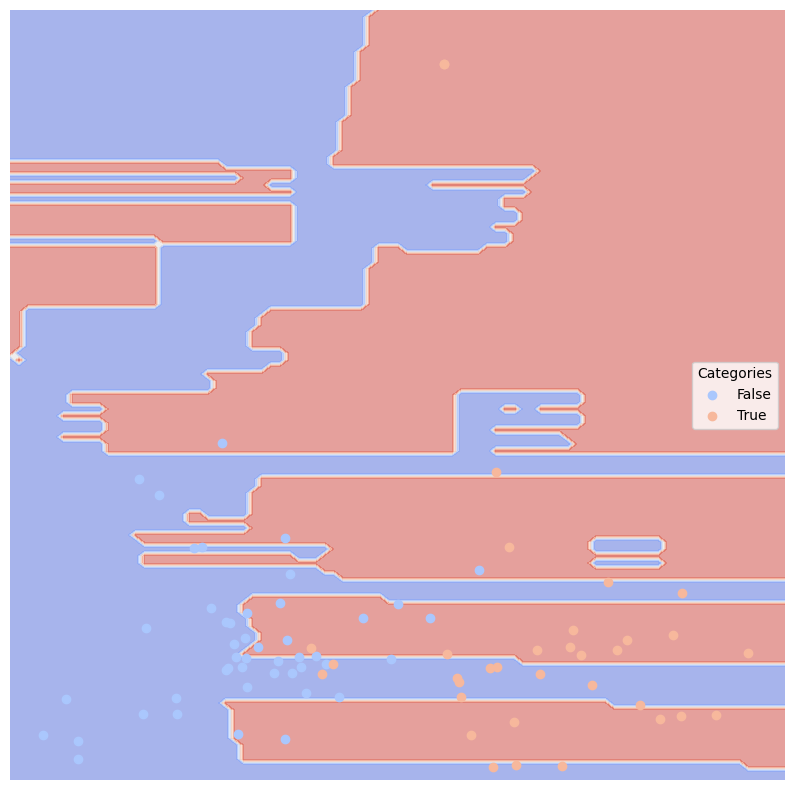

In [ ]:
lucem_illud.plotregions(clf_knearest, train_ng_df)

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['cleaned_review'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.5


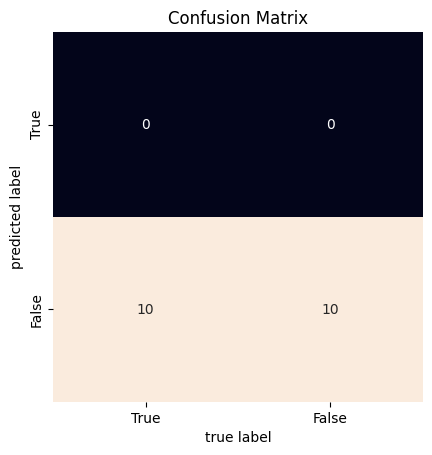

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


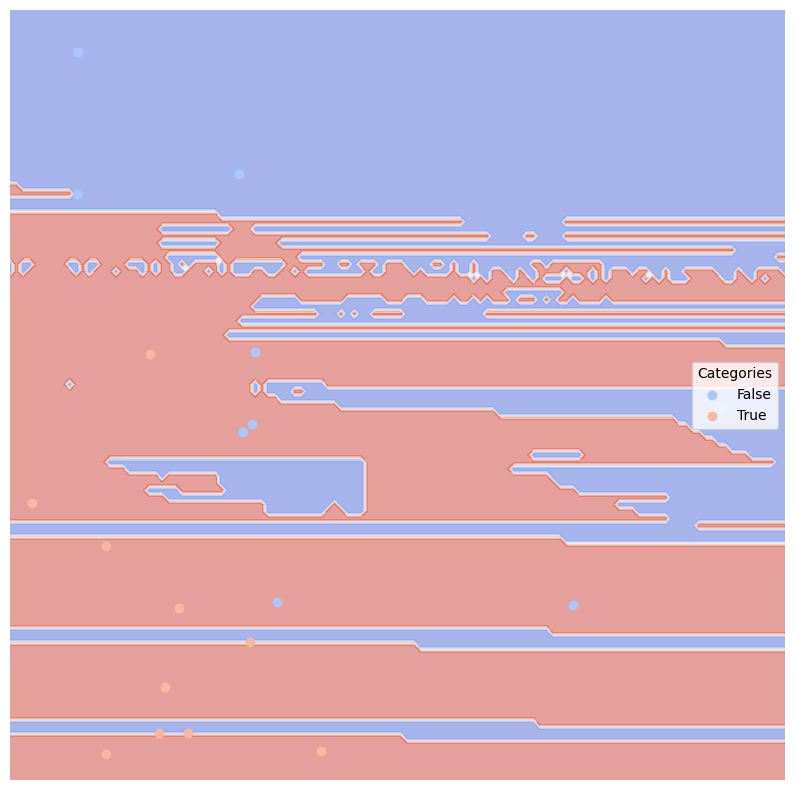

In [ ]:
lucem_illud.plotregions(clf_knearest, test_ng_df)

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, test_ng_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.5,0.5,0.0,0.5,0.0
True,0.5,0.5,0.5,0.5,1.0


### Overly complex regions can be a sign of overfitting in this model, where the model has learned to fit the noise in the training data rather than the actual underlying pattern.Effect is not good.

### Both algorithms calculate distances between data points in the feature space. They both have a parameter 'k', but in KNN, it represents the number of neighbors to consider, whereas in k-means, it represents the number of clusters to form.

### KNN uses distances to make predictions for new data points based on labeled data, while k-means uses distances to group data points into clusters without prior labels. While KNN requires labeled data, k-means finds structure in unlabeled data.

### In KNN (k-nearest neighbors). KNN works with labeled data. It uses the labels of the 'k' nearest data points (where 'k' is a user-defined constant) to predict the label of a new, unlabeled data point. The proximity of these neighbors is calculated using a distance metric such as Euclidean, Manhattan, or Hamming distance.

### K-means deals with unlabeled data. The goal is to group similar data points together and discover underlying patterns. It partitions the dataset into 'k' distinct non-overlapping subgroups (clusters) based on the features provided, not on any external labeling.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0) # replace path if on Colab

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $z = w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $f(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" style="width:500px">

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

In [ ]:
Ba_df

,cleaned_review,score,num_comments,word_count,title_word_count,Burnout evaluation,created_utc_converted,Burnout_evaluation,category,tokenized_text,normalized_text
0,my nine month old absolutely loves it when I s...,2,7,53,7,0.0,2020-05-19 22:44:10,0.0,False,"[my, nine, month, old, absolutely, loves, it, ...","[month, old, absolutely, love, sing, try, sing..."
1,Hi So for a little background information I ...,2,1,247,11,1.0,2021-12-19 02:52:37,1.0,True,"[Hi, So, for, a, little, background, informati...","[hi, little, background, information, ve, grea..."
2,When I am mad or very sad I have the urge to ...,3,2,38,7,0.0,2022-09-19 11:35:02,0.0,False,"[When, I, am, mad, or, very, sad, I, have, the...","[mad, sad, urge, improve, life, experience, gl..."
3,Basically I am getting distracted because I am...,2,2,125,9,1.0,2022-07-12 03:55:16,1.0,True,"[Basically, I, am, getting, distracted, becaus...","[basically, get, distract, stress, work, turn,..."
4,I wasn t sure how to flair this so let me know...,3,1,279,16,1.0,2018-08-17 06:03:21,1.0,True,"[I, wasn, t, sure, how, to, flair, this, so, l...","[wasn, t, sure, flair, let, know, fit, well, f..."
...,...,...,...,...,...,...,...,...,...,...,...
95,I m have been an iron work construction s...,1,2,98,6,1.0,2021-03-02 05:31:34,1.0,True,"[I, m, have, been, an, iron, work, constructio...","[m, iron, work, construction, small, company, ..."
96,I work with seniors who are low income have m...,10,3,232,11,1.0,2019-05-29 21:32:20,1.0,True,"[I, work, with, seniors, who, are, low, income...","[work, senior, low, income, mental, illness, d..."
97,I want a workout that I can do every day witho...,1,3,49,7,0.0,2013-09-03 17:05:09,0.0,False,"[I, want, a, workout, that, I, can, do, every,...","[want, workout, day, harm, body, start, strong..."
98,My AGM decided to schedule me days in a row ...,20,9,384,6,1.0,2022-04-03 18:26:16,1.0,True,"[My, AGM, decided, to, schedule, me, days, in,...","[agm, decide, schedule, day, row, way, pay, pe..."


In [ ]:
baTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
baTFVects = baTFVectorizer.fit_transform([' '.join(l) for l in Ba_df['normalized_text']])
Ba_df['vect'] = [np.array(v).flatten() for v in baTFVects.todense()]

In [ ]:
holdBackFraction = .2
train_BaDf, test_BaDf = sklearn.model_selection.train_test_split(Ba_df, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_BaDf['vect'], axis=0), train_BaDf['category'])

SVC(kernel='linear')

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_BaDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.15,0.863636,0.75,0.750000,1.000000
True,0.15,0.863636,1.00,0.877273,0.727273


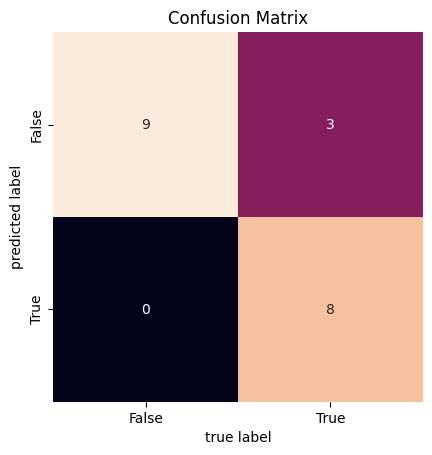

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_BaDf)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


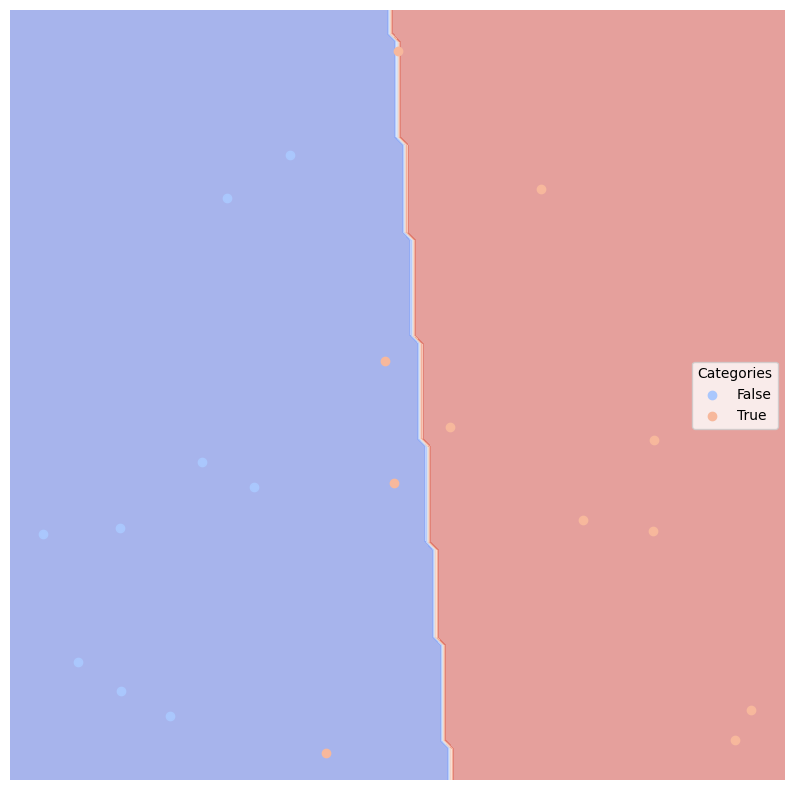

In [ ]:
lucem_illud.plotregions(clf_svm, test_BaDf)

### svm seem have better result

### For this small case, the classify of k-nearest neighbor, logistic and decision-tree approaches given a very conplex plot. It may have overfit risk base some nosie.

### From these results, we can infer that the classifier is more conservative in predicting "True," as evidenced by the perfect accuracy but lower recall rate of "True." It doesn't miss any "False" instances, but tends to misclassify some "True" instances as "False".



### The classifiers generally performed well, achieving particularly good results in identifying "error" categories. However, the recall rate in the "real" category has room for improvement.

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [pytorch version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/pytorch/text-classification/run_glue.py) and
[pytorch-lightning version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/pytorch-lightning/run_glue.py)(legacy) or
[tensorflow version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/tensorflow/text-classification/run_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [ ]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

label: NEGATIVE, with score: 0.9991
label: POSITIVE, with score: 0.9999


Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

not paraphrase: 10%
is paraphrase: 90%
not paraphrase: 94%
is paraphrase: 6%


### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/question-answering/run_squad.py) (legacy) script.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/legacy/question-answering/run_squad.py
"""

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'the task of extracting an answer from a text given a question', score: 0.6329, start: 34, end: 95
Answer: 'SQuAD dataset', score: 0.5102, start: 147, end: 160


Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Question: How many pretrained models are available in 🤗 Transformers?
Answer: over 32 +
Question: What does 🤗 Transformers provide?
Answer: general - purpose architectures
Question: 🤗 Transformers provides interoperability between which frameworks?
Answer: tensorflow 2. 0 and pytorch


## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/legacy/question-answering/run_squad.py
"""

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'the task of extracting an answer from a text given a question', score: 0.6329, start: 34, end: 95
Answer: 'SQuAD dataset', score: 0.5102, start: 147, end: 160


In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
Last week, my boss called me into her office. The conversation began with, essentially, an accusation. She told me that she suspected that I had become disgruntled and dissatisfied and that I was intentionally underperforming.
Her reasoning was that over the last six months or so, she's removed some responsibilities for, basically, noncritical background processes off of my plate, and last week and the week before that, I had trouble getting some little "other duties as assigned" stuff complete on time, basically filing paperwork. At no point were any complaints about the quality of the actual work that I do mentioned.
A year ago in April, one of my colleagues got fired and I inherited her workload. I had a lot of responsibilities to a lot of people, who relied on me to get their work done. And over the last year,
even as a few things have been taken off of my plate, the complexity and volume and expectations about how quickly I will complete my work have continually increased.
I got a promotion and a raise, but the amount was disappointing and definitely not commensurate with the new and increasing expectations of me, so I went the office manager (who has really no way of appreciating what I do or how difficult it is) to discuss my compensation, and they told me that there's nothing they can do. I'm supporting more people, being forced to learn new systems and change the way I work, increase my value to the firm, etc., but this is just the baseline expectation. "Stepping up" (how one of the partners describes the ideal level of engagement from us in order to meet the goal of increasing revenue by 60 percent in four years) is the minimum acceptable level of effort.
And I eat at my desk, so I can get more work done. So, no, I don't want to be constantly reminded that people who don't work half as hard as me make so much more money than I do, that I am breaking my body and my mind to make their lives easier.
With no support, no concessions, just grin and bear it some more, again. Fuck that..
"""
questions = [
    "What was the employee's approach to discussing compensation with the office manager?",
    "What changes occurred in the employee's workload over the last year?",
    "What is the employee's perspective on the effort required to meet the firm's revenue goals?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Question: What was the employee's approach to discussing compensation with the office manager?
Answer: there ' s nothing they can do
Question: What changes occurred in the employee's workload over the last year?
Answer: the complexity and volume and expectations about how quickly i will complete my work have continually increased
Question: What is the employee's perspective on the effort required to meet the firm's revenue goals?
Answer: stepping up


In [ ]:
text = r"""
I work with seniors who are low income, have mental illnesses and other disabilities.
I would like to find meaning in this work, but most of the time I feel like I'm a "duct taper".
Most people I work with are really isolated, some have no friends or family at all. So my interactions with that person might be important to them, but I really don't feel like I'm making a difference.
Even if someone tells me I helped them, I feel nothing, even though I do empathize and care.
For me, I think years of suicidal ideation are also taking their toll, making me feel obligated to constantly be justifying my purpose to myself.
But I think it also has to do with expectation vs. reality, and pretty much omnipresent burnout.
I've done other types of jobs, like especially pointless data entry, and that was much worse, but I'm getting weary of my constant job-related dark night of the soul. I'm 34.
I know most of us here want to limit/do away with paid employment, but I'm interested in hearing from folks in my field, how are you coping? and do you think your job is sustainable for your own mental health?
Do you feel like you're succeeding in helping people or improving their lives? Do you feel disconnected from the work?.
"""
questions = [
    "What challenges does the individual face in finding meaning in their work with low-income seniors with mental illnesses and disabilities?",
    "How does the individual describe their feelings towards the impact of their work on others?",
    "What concerns does the individual express about the sustainability of their job for their own mental health?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

Question: What challenges does the individual face in finding meaning in their work with low-income seniors with mental illnesses and disabilities?
Answer: most of the time i feel like i ' m a " duct taper "
Question: How does the individual describe their feelings towards the impact of their work on others?
Answer: duct taper "
Question: What concerns does the individual express about the sustainability of their job for their own mental health?
Answer: succeeding in helping people or improving their lives


### Regarding the BERT model for question-answering,due to its deep bidirectional training and ability to capture context from both left and right of a token within the text. It helps in gaining insights by providing more accurate representations of word meanings based on the surrounding text, which can be different from prior methods like word2vec or GloVe that provide a single static representation for each word. BERT's context-aware embeddings allow for a better understanding of the nuances and complexities of language, which can be particularly useful for interpreting the meaning and sentiment of texts related to your research.


### And because the pipeline has been packaged, it is also very convenient when calling, and there is no need to re-train a large number of corpora, resulting in a waste of computer resources and time.


### By BERT question-answering in the model, I can get the main cause of such emotion from the burnout text and even get a more detailed description of the scene. It can help me better understand the context in which different emotions occur.